### Course Popularity - Final Project for CSC440: Data Mining


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import gc
import sys
import io

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# ============================================================
# 0. Load CSVs
# ============================================================
sections_file_path = Path("Data") / "Course_data" / "courses.sections.csv"
sectionsTS_file_path = Path("Data") / "Course_data" / "courses.sectionsTS.csv"

# Paths for trimmed files
sections_trimmed_path = Path("Data") / "Course_data" / "courses.sections-trimmed.csv"
sections_ts_trimmed_path = Path("Data") / "Course_data" / "courses.sectionsTS-trimmed.csv"

# Only load original full CSVs if trimmed versions don't exist
if sections_trimmed_path.exists() and sections_ts_trimmed_path.exists():
    print("Trimmed files already exist. Skipping loading of original full CSV files.")
    print("(Original files will be loaded from trimmed versions in the next cell)")
    sections_df = None
    sections_ts_df = None
else:
    sections_df = pd.read_csv(sections_file_path, low_memory=False)
    sections_ts_df = pd.read_csv(sectionsTS_file_path)

    print("\n========== Loaded Datasets ==========")
    print("courses.sections.csv info:")
    print(sections_df.info(), "\n")

    print("courses.sectionsTS.csv info:")
    print(sections_ts_df.info(), "\n")

    print("Static sections columns:", sections_df.columns)
    print("Time-series columns:", sections_ts_df.columns)

Trimmed files already exist. Skipping loading of original full CSV files.
(Original files will be loaded from trimmed versions in the next cell)


In [5]:
# ============================================================
# 0.1 Filter datasets to Spring 2025 only and export trimmed CSVs
# ============================================================

# Define paths for trimmed files
sections_ts_trimmed_path = Path("Data") / "Course_data" / "courses.sectionsTS-trimmed.csv"
sections_trimmed_path = Path("Data") / "Course_data" / "courses.sections-trimmed.csv"

# Check if trimmed files already exist
if sections_ts_trimmed_path.exists():
    print(f"Trimmed file already exists: {sections_ts_trimmed_path} (skipping creation)")
else:
    # Filter courses.sectionsTS.csv for Spring 2025
    # Note: courseInfo.year may be int or string, so we handle both
    sections_ts_trimmed = sections_ts_df[
        (sections_ts_df["courseInfo.semester"] == "Spring") & 
        (sections_ts_df["courseInfo.year"].astype(str) == "2025")
    ].copy()
    
    print(f"courses.sectionsTS.csv: {len(sections_ts_df)} rows -> {len(sections_ts_trimmed)} rows (Spring 2025 only)")
    
    # --------------------------------------------------------
    # Fix duplicate / typo columns: waitlistAvailable vs wailistAvailable
    # Merge data from typo column into correct column, then drop typo column
    # --------------------------------------------------------
    if "waitlistAvailable" in sections_ts_trimmed.columns and "wailistAvailable" in sections_ts_trimmed.columns:
        col_good = sections_ts_trimmed["waitlistAvailable"]
        col_typo = sections_ts_trimmed["wailistAvailable"]

        # Where both have values and differ, count mismatches
        both_non_null = col_good.notna() & col_typo.notna()
        mismatches = (both_non_null & (col_good != col_typo)).sum()

        print(f"\n[Data Fix] waitlistAvailable vs wailistAvailable:")
        print(f"  Rows where BOTH are non-null: {both_non_null.sum()}")
        print(f"  Rows where values MISMATCH:  {mismatches}")

        # Merge logic (intersection-style):
        # - If both non-null and equal → keep that value
        # - If only one is non-null   → use the non-null value
        # - If both non-null and different → set NaN (and rely on later checks)
        merged = np.where(
            both_non_null & (col_good == col_typo),
            col_good,                     # agree → keep
            np.where(
                col_good.notna() & ~col_typo.notna(),
                col_good,                 # only good has value
                np.where(
                    col_typo.notna() & ~col_good.notna(),
                    col_typo,             # only typo has value
                    np.nan                # mismatch or both null
                )
            )
        )

        sections_ts_trimmed["waitlistAvailable"] = merged

        # Drop the typo column
        sections_ts_trimmed = sections_ts_trimmed.drop(columns=["wailistAvailable"])

        print("  -> Merged into 'waitlistAvailable' and dropped 'wailistAvailable'.")
    else:
        print("\n[Data Fix] One or both columns 'waitlistAvailable' / 'wailistAvailable' not found; no merge performed.")
    
    # --------------------------------------------------------
    # Reorder timeseries data: group by courseInfo.classNumber
    # (maintaining first-appearance order) and sort by dateTimeRetrieved within each group
    # --------------------------------------------------------
    
    # Get unique classNumbers in order of first appearance
    unique_class_numbers_ordered = sections_ts_trimmed["courseInfo.classNumber"].drop_duplicates().tolist()
    print(f"Found {len(unique_class_numbers_ordered)} unique courses in order of first appearance")
    
    # Convert dateTimeRetrieved to datetime for proper sorting
    sections_ts_trimmed["dateTimeRetrieved"] = pd.to_datetime(sections_ts_trimmed["dateTimeRetrieved"], errors="coerce")
    
    # Create a categorical column to preserve the first-appearance order of classNumbers
    sections_ts_trimmed["classNumber_order"] = pd.Categorical(
        sections_ts_trimmed["courseInfo.classNumber"],
        categories=unique_class_numbers_ordered,
        ordered=True
    )
    
    # Sort by classNumber (first-appearance order) then by dateTimeRetrieved within each group
    sections_ts_trimmed = sections_ts_trimmed.sort_values(
        by=["classNumber_order", "dateTimeRetrieved"],
        ascending=[True, True]
    ).reset_index(drop=True)
    
    # Drop the temporary ordering column
    sections_ts_trimmed = sections_ts_trimmed.drop(columns=["classNumber_order"])
    
    print(f"Reordered timeseries data: grouped by courseInfo.classNumber, sorted by dateTimeRetrieved within each group")
    print(f"First 3 courses in order: {unique_class_numbers_ordered[:3]}")
    
    # Export trimmed and reordered sectionsTS to CSV
    sections_ts_trimmed.to_csv(sections_ts_trimmed_path, index=False)
    print(f"Saved: {sections_ts_trimmed_path}")

if sections_trimmed_path.exists():
    print(f"Trimmed file already exists: {sections_trimmed_path} (skipping creation)")
else:
    # Filter courses.sections.csv for Spring 2025
    # Note: year may be int or string, so we handle both
    sections_trimmed = sections_df[
        (sections_df["semester"] == "Spring") & 
        (sections_df["year"].astype(str) == "2025")
    ].copy()
    
    print(f"courses.sections.csv: {len(sections_df)} rows -> {len(sections_trimmed)} rows (Spring 2025 only)")
    
    # Export trimmed sections to CSV
    sections_trimmed.to_csv(sections_trimmed_path, index=False)
    print(f"Saved: {sections_trimmed_path}")

# ============================================================
# 0.2 Import the trimmed CSV files for further processing
# ============================================================

# Load the trimmed datasets
sections_df = pd.read_csv(sections_trimmed_path, low_memory=False)
sections_ts_df = pd.read_csv(sections_ts_trimmed_path)

print("\n========== Loaded Trimmed Datasets ==========")
print(f"courses.sections-trimmed.csv: {len(sections_df)} rows, {len(sections_df.columns)} columns")
print(f"courses.sectionsTS-trimmed.csv: {len(sections_ts_df)} rows, {len(sections_ts_df.columns)} columns")


Trimmed file already exists: Data/Course_data/courses.sectionsTS-trimmed.csv (skipping creation)
Trimmed file already exists: Data/Course_data/courses.sections-trimmed.csv (skipping creation)

========== Loaded Trimmed Datasets ==========
courses.sections-trimmed.csv: 7513 rows, 162 columns
courses.sectionsTS-trimmed.csv: 1060659 rows, 9 columns


In [31]:
### ONLY RUN THIS CELL IF YOU WANT TO BUILD THE DATA QUALITY REPORT FOR A NEW TRIMMED CSV FILE ###
### OTHERWISE, SKIP THIS CELL AS RUNTIME IS LONG: 3 MIN 30 SECONDS ###

# ============================================================
# 1. Helper: Build Data Quality Report for a DataFrame
# ============================================================

def build_dq_report(df: pd.DataFrame, df_name: str):
    """
    Perform data quality checks, print all results, and return BOTH:
    - cleaned DataFrame
    - string report suitable for writing to a .txt file

    Special handling:
    - Treat 'courseInfo.classNumber' and 'courseInfo.year' as categorical,
      even if they are stored as numbers.
    """
    output = []  # collect all console lines into a list

    def log(msg=""):
        print(msg)
        output.append(str(msg))

    # ---------- Force certain numeric-looking columns to categorical ----------
    forced_categorical_cols = ["courseInfo.classNumber", "courseInfo.year"]
    for col in forced_categorical_cols:
        if col in df.columns:
            # Cast to string dtype so they behave like categorical/text
            df[col] = df[col].astype("string")

    log("\n\n============================================================")
    log(f"############  DATA QUALITY REPORT: {df_name}  ############")
    log("============================================================\n")

    # ---------- Overview ----------
    log("---- Overview ----")
    overview = pd.DataFrame({
        "n_rows": [df.shape[0]],
        "n_columns": [df.shape[1]],
        "n_duplicates": [df.duplicated().sum()]
    })
    log(overview.to_string())
    log("")

    # ---------- classNumber Uniqueness Check (for courses.sections.csv only) ----------
    # Each row in courses.sections-trimmed.csv should have a unique classNumber
    if "classNumber" in df.columns and "sectionsTS" not in df_name:
        log("---- classNumber Uniqueness Check ----")
        
        # Find duplicate classNumber values
        duplicate_mask = df["classNumber"].duplicated(keep=False)
        n_duplicates = duplicate_mask.sum()
        
        if n_duplicates == 0:
            log("All classNumber values are unique (no duplicates found)")
        else:
            log(f"WARNING: Found {n_duplicates} rows with duplicate classNumber values!")
            
            # Get the duplicate rows
            duplicate_rows = df[duplicate_mask].copy()
            duplicate_class_numbers = duplicate_rows["classNumber"].unique()
            log(f"  Number of classNumber values that appear more than once: {len(duplicate_class_numbers)}")
            
            # Show details for each duplicate classNumber
            log("\n  Duplicate classNumber details:")
            for class_num in duplicate_class_numbers[:20]:  # Limit to first 20 to avoid overwhelming output
                dup_indices = df[df["classNumber"] == class_num].index.tolist()
                log(f"    classNumber {class_num}: found at indices {dup_indices}")
            
            if len(duplicate_class_numbers) > 20:
                log(f"    ... and {len(duplicate_class_numbers) - 20} more duplicate classNumbers (truncated)")
            
            # Show sample of duplicate rows
            log("\n  Sample duplicate rows (first 10):")
            sample_cols = ["classNumber", "subjectCode", "catalogNumber", "name", "sectionType"]
            available_cols = [c for c in sample_cols if c in duplicate_rows.columns]
            log(duplicate_rows[available_cols].head(10).to_string())
        
        log("")

    # ---------- Null Summary ----------
    log("---- Null Summary (All Columns) ----")
    null_summary = pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.values.astype(str),
        "null_count": df.isna().sum().values,
        "null_pct": (df.isna().mean() * 100).values
    }).sort_values("null_pct", ascending=False)
    log(null_summary.to_string(index=False))
    log("")

    # ---------- Completely Empty Columns Check ----------
    log("---- Completely Empty Columns (100% Null) ----")
    
    # Find columns where all values are null (no data at all)
    empty_cols = [col for col in df.columns if df[col].isna().all()]
    
    if len(empty_cols) == 0:
        log("No completely empty columns found - all columns have at least some data")
    else:
        log(f"WARNING: Found {len(empty_cols)} columns with NO data (100% null):")
        for i, col in enumerate(empty_cols, 1):
            log(f"  {i}. {col} (dtype: {df[col].dtype})")
        
        log(f"\n  These columns contain no useful data and could be considered for removal.")
    log("")

    # ---------- Dtype Summary ----------
    log("---- Dtype Summary ----")
    dtype_summary = (
        null_summary[["column", "dtype"]]
        .groupby("dtype")
        .agg(n_columns=("column", "count"),
             columns=("column", lambda x: ", ".join(x)))
        .reset_index()
    )
    log(dtype_summary.to_string(index=False))
    log("")

    # ---------- Numeric Summary ----------
    log("---- Numeric Summary ----")

    numeric_cols = df.select_dtypes(include=[np.number]).columns  # numeric columns
    ignore_cols = {"courseInfo.classNumber", "courseInfo.year"}   # columns to treat as categorical
    numeric_cols = [c for c in numeric_cols if c not in ignore_cols]  # filter them out

    if len(numeric_cols) > 0:
        numeric_summary = df[numeric_cols].describe().T
        numeric_summary["missing_count"] = df[numeric_cols].isna().sum()
        numeric_summary["missing_pct"] = df[numeric_cols].isna().mean() * 100
        log(numeric_summary.to_string())
    else:
        log("No numeric columns.")
    log("")

    # ---------- Categorical Summary ----------
    log("---- Categorical Summary ----")
    cat_cols = df.select_dtypes(include=["object", "category", "string"]).columns
    cat_summary_rows = []

    for col in cat_cols:
        series = df[col]

        # SPECIAL CASE: Avoid lists of large uniques value-counts in columns
        if (col in ["_id", "name", "dateTimeRetrieved", "sectionCode", "courseInfo.classNumber"] or 
            col.startswith("instructor") or col.startswith("classroom") or 
            col.startswith("timeStart") or col.startswith("timeEnd") or
            col.startswith("startDate") or col.startswith("endDate")):

            value_counts_str = "[SKIPPED - too many unique values]"
        else:
            # full list of value counts
            value_counts_str = ", ".join(
                [f"{idx}({val})" for idx, val in series.value_counts(dropna=True).items()]
            )

        cat_summary_rows.append({
            "column": col,
            "dtype": str(series.dtype),
            "n_unique": series.nunique(dropna=True),
            "missing_pct": series.isna().mean() * 100,
            "value_counts": value_counts_str
        })

    if cat_summary_rows:
        cat_summary = pd.DataFrame(cat_summary_rows)
        log(cat_summary.to_string(index=False))
    else:
        log("No categorical columns.")
    log("")

    # ---------- Type Coercion Checks ----------
    log("---- Type Coercion Checks ----")

    expected_numeric_cols = [
        "capacity", "waitlistCapacity", "reservedSeatsAvailable",
        "reservedSeatsCapacity", "year", "catalogNumber", "classNumber"
        # NOTE: we do NOT include 'courseInfo.classNumber' or 'courseInfo.year' here
    ]
    expected_datetime_cols = [
        "dateTimeRetrieved", "timeStart", "timeEnd",
        "startDate", "endDate"
    ]

    log("\nNumeric Columns Coercion Results:")
    for col in expected_numeric_cols:
        if col in df.columns:
            before = df[col].notna().sum()
            coerced = pd.to_numeric(df[col], errors="coerce")
            after = coerced.notna().sum()
            log(f"{col}: non-null before={before}, after={after}, invalid={before - after}")
            df[col] = coerced

    log("\nDatetime Columns Coercion Results:")
    for col in expected_datetime_cols:
        if col in df.columns:
            before = df[col].notna().sum()
            coerced = pd.to_datetime(df[col], errors="coerce")
            after = coerced.notna().sum()
            log(f"{col}: non-null before={before}, after={after}, invalid={before - after}")
            df[col] = coerced

    # ==========================================================================
    # DATA VALIDATION CHECKS (Specific to trimmed CSV files)
    # ==========================================================================
    log("\n---- Data Validation Checks ----")
    
    # ---------- Validation for courses.sectionsTS-trimmed.csv ----------
    if "sectionsTS" in df_name:
        log("\n[Validating courses.sectionsTS-trimmed.csv]")
        
        # 1. Check that dateTimeRetrieved is increasing for each courseInfo.classNumber
        log("\n  1. dateTimeRetrieved ordering check (must be increasing per course):")
        if "dateTimeRetrieved" in df.columns and "courseInfo.classNumber" in df.columns:
            # Convert to datetime if not already
            df["dateTimeRetrieved"] = pd.to_datetime(df["dateTimeRetrieved"], errors="coerce")
            
            # Check if dates are sorted within each course group
            violations = []
            for class_num in df["courseInfo.classNumber"].unique():
                course_data = df[df["courseInfo.classNumber"] == class_num]["dateTimeRetrieved"]
                if not course_data.is_monotonic_increasing:
                    # Find specific rows where order is violated
                    course_indices = course_data.index.tolist()
                    for i in range(1, len(course_data)):
                        if course_data.iloc[i] < course_data.iloc[i-1]:
                            violations.append({
                                "classNumber": class_num,
                                "index": course_indices[i],
                                "prev_date": course_data.iloc[i-1],
                                "curr_date": course_data.iloc[i]
                            })
            
            if len(violations) == 0:
                log("     ✓ All dateTimeRetrieved values are properly ordered (increasing) per course")
            else:
                log(f"     ⚠ WARNING: Found {len(violations)} ordering violations!")
                for v in violations[:10]:  # Show first 10
                    log(f"       classNumber {v['classNumber']}, index {v['index']}: {v['curr_date']} < {v['prev_date']}")
                if len(violations) > 10:
                    log(f"       ... and {len(violations) - 10} more violations (truncated)")
        else:
            log("     ⚠ Required columns not found for this check")
        
        # 2. Check courseInfo.semester must be only "Spring"
        log("\n  2. courseInfo.semester value check (must be 'Spring' only):")
        if "courseInfo.semester" in df.columns:
            unique_semesters = df["courseInfo.semester"].unique()
            invalid_semesters = [s for s in unique_semesters if s != "Spring"]
            if len(invalid_semesters) == 0:
                log(f"     ✓ All values are 'Spring' (unique values: {list(unique_semesters)})")
            else:
                log(f"     ⚠ WARNING: Found invalid semester values: {invalid_semesters}")
                for sem in invalid_semesters:
                    count = (df["courseInfo.semester"] == sem).sum()
                    log(f"       '{sem}': {count} rows")
        else:
            log("     ⚠ Column 'courseInfo.semester' not found")
        
        # 3. Check courseInfo.year must be only "2025"
        log("\n  3. courseInfo.year value check (must be '2025' only):")
        if "courseInfo.year" in df.columns:
            unique_years = df["courseInfo.year"].astype(str).unique()
            invalid_years = [y for y in unique_years if y != "2025"]
            if len(invalid_years) == 0:
                log(f"     ✓ All values are '2025' (unique values: {list(unique_years)})")
            else:
                log(f"     ⚠ WARNING: Found invalid year values: {invalid_years}")
                for yr in invalid_years:
                    count = (df["courseInfo.year"].astype(str) == yr).sum()
                    log(f"       '{yr}': {count} rows")
        else:
            log("     ⚠ Column 'courseInfo.year' not found")
        
        # 4. Check _id must be unique
        log("\n  4. _id uniqueness check:")
        if "_id" in df.columns:
            duplicate_ids = df["_id"].duplicated()
            n_duplicates = duplicate_ids.sum()
            if n_duplicates == 0:
                log(f"     ✓ All _id values are unique ({df['_id'].nunique()} unique values)")
            else:
                log(f"     ⚠ WARNING: Found {n_duplicates} duplicate _id values!")
                dup_id_values = df[duplicate_ids]["_id"].unique()[:10]
                log(f"       Sample duplicate _ids: {list(dup_id_values)}")
        else:
            log("     ⚠ Column '_id' not found")
    
    # ---------- Validation for courses.sections-trimmed.csv ----------
    elif "sections" in df_name and "sectionsTS" not in df_name:
        log("\n[Validating courses.sections-trimmed.csv]")
        
        # 1. Check _id must be unique
        log("\n  1. _id uniqueness check:")
        if "_id" in df.columns:
            duplicate_ids = df["_id"].duplicated()
            n_duplicates = duplicate_ids.sum()
            if n_duplicates == 0:
                log(f"     ✓ All _id values are unique ({df['_id'].nunique()} unique values)")
            else:
                log(f"     ⚠ WARNING: Found {n_duplicates} duplicate _id values!")
                dup_id_values = df[duplicate_ids]["_id"].unique()[:10]
                log(f"       Sample duplicate _ids: {list(dup_id_values)}")
        else:
            log("     ⚠ Column '_id' not found")
        
        # 2. Check academicCareer must be "Undergraduate" or "Graduate"
        log("\n  2. academicCareer value check (must be 'Undergraduate' or 'Graduate'):")
        if "academicCareer" in df.columns:
            valid_careers = {"Undergraduate", "Graduate"}
            unique_careers = set(df["academicCareer"].dropna().unique())
            invalid_careers = unique_careers - valid_careers
            if len(invalid_careers) == 0:
                log(f"     ✓ All values are valid (unique values: {unique_careers})")
            else:
                log(f"     ⚠ WARNING: Found invalid academicCareer values: {invalid_careers}")
                for career in invalid_careers:
                    count = (df["academicCareer"] == career).sum()
                    log(f"       '{career}': {count} rows")
        else:
            log("     ⚠ Column 'academicCareer' not found")
        
        # 3. Check year must be only "2025"
        log("\n  3. year value check (must be '2025' only):")
        if "year" in df.columns:
            unique_years = df["year"].astype(str).unique()
            invalid_years = [y for y in unique_years if y != "2025"]
            if len(invalid_years) == 0:
                log(f"     ✓ All values are '2025' (unique values: {list(unique_years)})")
            else:
                log(f"     ⚠ WARNING: Found invalid year values: {invalid_years}")
                for yr in invalid_years:
                    count = (df["year"].astype(str) == yr).sum()
                    log(f"       '{yr}': {count} rows")
        else:
            log("     ⚠ Column 'year' not found")
        
        # 4. Check semester must be only "Spring"
        log("\n  4. semester value check (must be 'Spring' only):")
        if "semester" in df.columns:
            unique_semesters = df["semester"].unique()
            invalid_semesters = [s for s in unique_semesters if s != "Spring"]
            if len(invalid_semesters) == 0:
                log(f"     ✓ All values are 'Spring' (unique values: {list(unique_semesters)})")
            else:
                log(f"     ⚠ WARNING: Found invalid semester values: {invalid_semesters}")
                for sem in invalid_semesters:
                    count = (df["semester"] == sem).sum()
                    log(f"       '{sem}': {count} rows")
        else:
            log("     ⚠ Column 'semester' not found")

    log(f"\n========== END OF REPORT FOR: {df_name} ==========\n")

    # Return cleaned df + FULL text output
    return df, "\n".join(output)

# ============================================================
# 2. Run Reports for Each Dataset
# ============================================================

sections_df, sections_report_txt = build_dq_report(sections_df.copy(), "courses.sections")
sections_ts_df, sectionsTS_report_txt = build_dq_report(sections_ts_df.copy(), "courses.sectionsTS")

gc.collect()

print("\n ########## Data quality analysis completed. ##########\n")

# ============================================================
# 3. SAVE REPORT TO TEXT FILE
# ============================================================

output_path = Path("Dataset-Report.txt")
with open(output_path, "w", encoding="utf-8") as f:
    f.write(sections_report_txt)
    f.write("\n\n")
    f.write(sectionsTS_report_txt)

print(f"Dataset report written to: {output_path.resolve()}")




############  DATA QUALITY REPORT: courses.sections  ############

---- Overview ----
   n_rows  n_columns  n_duplicates
0    7513        162             0

---- classNumber Uniqueness Check ----
All classNumber values are unique (no duplicates found)

---- Null Summary (All Columns) ----
                column   dtype  null_count   null_pct
              topic[4] float64        7513 100.000000
      instructor[5][2] float64        7513 100.000000
            timeEnd[8] float64        7513 100.000000
        instructor[11] float64        7513 100.000000
        instructor[12] float64        7513 100.000000
      instructor[5][1] float64        7513 100.000000
      instructor[4][4] float64        7513 100.000000
      instructor[4][3] float64        7513 100.000000
      instructor[4][2] float64        7513 100.000000
      instructor[3][5] float64        7513 100.000000
      instructor[3][4] float64        7513 100.000000
      instructor[3][3] float64        7513 100.000000
      

In [6]:
# ===============================================================
# 2. Merge Static Course Metadata with Time-Series Observations
#    (Intersection merge on classNumber + semester + year)
#    Timeseries data is aggregated into arrays to preserve row count
# ===============================================================

# Reload fresh data from trimmed file to ensure subjectCode is preserved correctly
sections_df_fresh = pd.read_csv(sections_trimmed_path, low_memory=False)

# Make a copy of the time-series dataframe to work with
sections_ts_copy = sections_ts_df.copy()

# Convert dateTimeRetrieved to datetime for proper handling
sections_ts_copy["dateTimeRetrieved"] = pd.to_datetime(sections_ts_copy["dateTimeRetrieved"], errors="coerce")

# --------------------------------------------------------
# Find overlapping column names (excluding merge keys)
# --------------------------------------------------------
sections_cols = set(sections_df_fresh.columns)
ts_cols = set(sections_ts_copy.columns)
overlapping_cols = sections_cols.intersection(ts_cols)

# Merge key columns from TS side (will be dropped after merge, not renamed)
merge_key_cols_ts = {"courseInfo.classNumber", "courseInfo.semester", "courseInfo.year"}
cols_to_rename = overlapping_cols - merge_key_cols_ts

print(f"Overlapping columns found: {overlapping_cols}")
print(f"Columns to rename with '-TS' suffix: {cols_to_rename}")

# Rename overlapping columns in the TS dataframe with "-TS" suffix
rename_dict = {col: f"{col}-TS" for col in cols_to_rename}
sections_ts_copy = sections_ts_copy.rename(columns=rename_dict)

# --------------------------------------------------------
# Ensure merge keys have compatible types
# --------------------------------------------------------
sections_df_fresh["classNumber"] = pd.to_numeric(sections_df_fresh["classNumber"], errors="coerce").astype("Int64")
sections_df_fresh["year"] = pd.to_numeric(sections_df_fresh["year"], errors="coerce").astype("Int64")
sections_df_fresh["semester"] = sections_df_fresh["semester"].astype(str)

sections_ts_copy["courseInfo.classNumber"] = pd.to_numeric(sections_ts_copy["courseInfo.classNumber"], errors="coerce").astype("Int64")
sections_ts_copy["courseInfo.year"] = pd.to_numeric(sections_ts_copy["courseInfo.year"], errors="coerce").astype("Int64")
sections_ts_copy["courseInfo.semester"] = sections_ts_copy["courseInfo.semester"].astype(str)

print(f"\nsections_df_fresh merge key dtypes:")
print(f"  classNumber: {sections_df_fresh['classNumber'].dtype}")
print(f"  semester: {sections_df_fresh['semester'].dtype}")
print(f"  year: {sections_df_fresh['year'].dtype}")
print(f"Unique subjectCodes in fresh data: {sections_df_fresh['subjectCode'].nunique()}")

# --------------------------------------------------------
# Aggregate timeseries data into arrays per course
# Group by courseInfo.classNumber, courseInfo.semester, courseInfo.year
# and collect all timeseries observations into lists/arrays
# --------------------------------------------------------
print("\nAggregating timeseries data into arrays per course...")

# Get columns to aggregate (all non-merge-key columns from TS)
ts_data_cols = [col for col in sections_ts_copy.columns 
                if col not in ["courseInfo.classNumber", "courseInfo.semester", "courseInfo.year"]]

print(f"Timeseries columns to aggregate: {ts_data_cols}")

# Create aggregation dictionary - collect each column into a list
agg_dict = {col: list for col in ts_data_cols}

# Group by merge keys and aggregate into lists
ts_aggregated = sections_ts_copy.groupby(
    ["courseInfo.classNumber", "courseInfo.semester", "courseInfo.year"],
    as_index=False
).agg(agg_dict)

# Add count of observations per course
ts_aggregated["ts_observation_count"] = ts_aggregated[ts_data_cols[0]].apply(len)

print(f"Aggregated timeseries shape: {ts_aggregated.shape}")
print(f"Sample observation counts: {ts_aggregated['ts_observation_count'].head().tolist()}")

# --------------------------------------------------------
# Perform intersection merge on classNumber + semester + year
# --------------------------------------------------------
df = sections_df_fresh.merge(
    ts_aggregated,
    left_on=["classNumber", "semester", "year"],
    right_on=["courseInfo.classNumber", "courseInfo.semester", "courseInfo.year"],
    how="inner"  # intersection merge
)

# Drop duplicate key columns from the TS side
df = df.drop(columns=["courseInfo.classNumber", "courseInfo.semester", "courseInfo.year"])

print(f"\n========== Merge Results ==========")
print(f"Original sections_df rows: {len(sections_df_fresh)}")
print(f"Merged dataframe rows: {len(df)}")
print(f"Merged dataframe columns: {len(df.columns)}")

# Show columns that came from TS file (with -TS suffix or ts_ prefix)
print(f"\nColumns with '-TS' suffix: {[c for c in df.columns if c.endswith('-TS')]}")
print(f"Timeseries array columns: {ts_data_cols}")
print(f"Observation count column: ts_observation_count")

# Display sample to verify merge success
print("\n========== Merged Dataset Sample ==========")
sample_cols = ["classNumber", "subjectCode", "catalogNumber", "semester", "year", "capacity", "ts_observation_count"]
available_sample_cols = [c for c in sample_cols if c in df.columns]
print(df[available_sample_cols].head(10))

# Show a sample of the nested timeseries data
print("\n========== Sample Timeseries Arrays (first course) ==========")
if len(df) > 0:
    first_row = df.iloc[0]
    print(f"Course: {first_row['classNumber']} - {first_row['subjectCode']} {first_row.get('catalogNumber', 'N/A')}")
    print(f"Number of timeseries observations: {first_row['ts_observation_count']}")
    if "dateTimeRetrieved" in df.columns:
        print(f"dateTimeRetrieved (first 5): {first_row['dateTimeRetrieved'][:5]}")
    if "seatsAvailable" in df.columns:
        print(f"seatsAvailable (first 5): {first_row['seatsAvailable'][:5]}")
    if "status" in df.columns:
        print(f"status (first 5): {first_row['status'][:5]}")


Overlapping columns found: {'_id', 'dateTimeRetrieved', 'reservedSeatsAvailable'}
Columns to rename with '-TS' suffix: {'_id', 'dateTimeRetrieved', 'reservedSeatsAvailable'}

sections_df_fresh merge key dtypes:
  classNumber: Int64
  semester: object
  year: Int64
Unique subjectCodes in fresh data: 130

Aggregating timeseries data into arrays per course...
Timeseries columns to aggregate: ['dateTimeRetrieved-TS', '_id-TS', 'seatsAvailable', 'status', 'waitlistAvailable', 'reservedSeatsAvailable-TS']
Aggregated timeseries shape: (7528, 10)
Sample observation counts: [148, 148, 148, 148, 44]

========== Merge Results ==========
Original sections_df rows: 7513
Merged dataframe rows: 7513
Merged dataframe columns: 169

Columns with '-TS' suffix: ['dateTimeRetrieved-TS', '_id-TS', 'reservedSeatsAvailable-TS']
Timeseries array columns: ['dateTimeRetrieved-TS', '_id-TS', 'seatsAvailable', 'status', 'waitlistAvailable', 'reservedSeatsAvailable-TS']
Observation count column: ts_observation_coun

Expanding timeseries arrays to flat dataframe...
Timeseries array columns to expand: ['seatsAvailable', 'status', 'waitlistAvailable', 'dateTimeRetrieved-TS', '_id-TS', 'reservedSeatsAvailable-TS']
Metadata columns to merge back: 161 columns
Expanded dataframe shape: (1060419, 167)
Course-level dataframe shape: (7513, 169)
Total timeseries observations: 1,060,419

Note: 'dateTimeRetrieved' in df_flat is the actual timeseries datetime (from sectionsTS)

FILTERING OUT COURSES WITH 0% FILL...
Courses before filtering: 7,513
Courses with 0% fill: 1,901
Courses after filtering: 5,612
Observations after filtering: 798,136


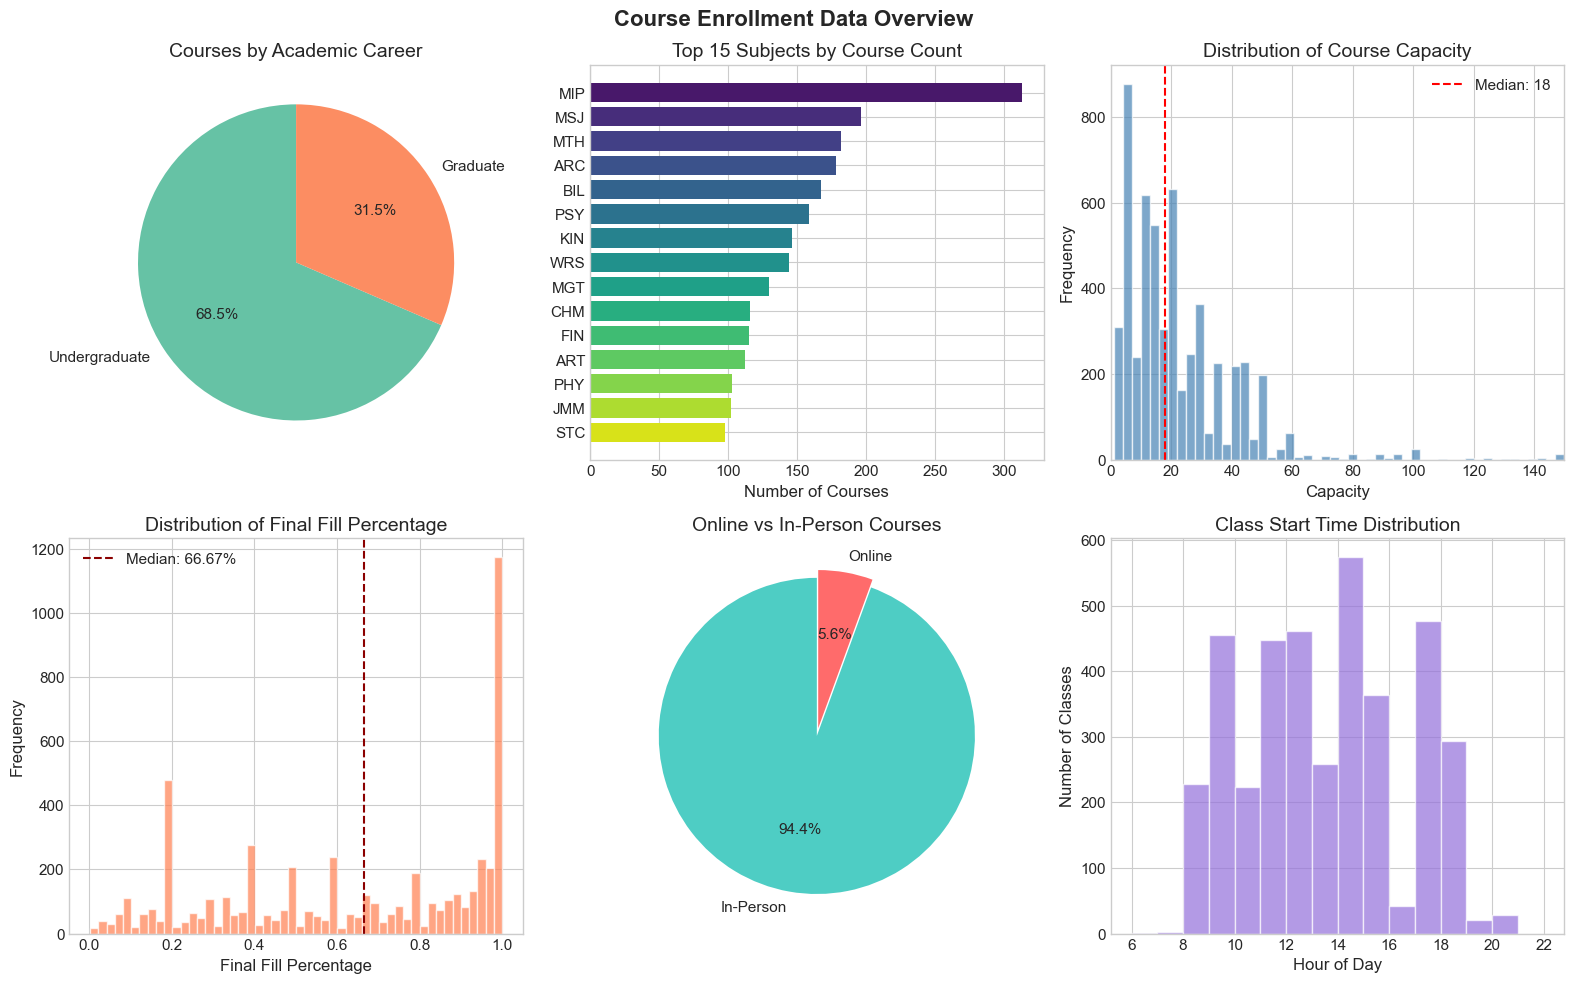


📊 Data Summary:
   Total courses: 5,612
   Total timeseries observations: 798,136
   Subject areas: 129
   Date range: 2024-11-04 to 2025-04-11


In [ ]:
# ===============================================================
# 2.1 Expand Array Data for Timeseries Analysis
# ===============================================================
# The merged df has timeseries data as arrays. For feature engineering and
# modeling, we need to expand this to one row per observation.
#
# NOTE: 
# - "dateTimeRetrieved" (from sections_df) = single poll timestamp (not relevant for timeseries)
# - "dateTimeRetrieved-TS" (from sections_ts_df) = actual timeseries timestamps (IMPORTANT)

print("Expanding timeseries arrays to flat dataframe...")

# Identify array columns (timeseries data stored as lists)
# These are the columns that contain lists from the aggregation
ts_array_cols = ['seatsAvailable', 'status', 'waitlistAvailable', 
                 'dateTimeRetrieved-TS', '_id-TS', 'reservedSeatsAvailable-TS']

# Check which columns actually exist in df
existing_ts_cols = [col for col in ts_array_cols if col in df.columns]
print(f"Timeseries array columns to expand: {existing_ts_cols}")

# Get non-array columns (course metadata) - exclude ts_observation_count, array columns,
# and the original dateTimeRetrieved (which is just a single poll timestamp, not timeseries data)
excluded_cols = set(existing_ts_cols) | {'ts_observation_count', 'dateTimeRetrieved'}
metadata_cols = [col for col in df.columns if col not in excluded_cols]
print(f"Metadata columns to merge back: {len(metadata_cols)} columns")

# Create expanded dataframe by exploding array columns
# Use pd.DataFrame.explode with multiple columns (pandas >= 1.3.0)
df_expanded = df[['classNumber'] + existing_ts_cols].copy()

# Explode all array columns at once
df_expanded = df_expanded.explode(existing_ts_cols, ignore_index=True)

# Rename columns: dateTimeRetrieved-TS becomes dateTimeRetrieved (the actual timeseries datetime)
rename_map = {
    'dateTimeRetrieved-TS': 'dateTimeRetrieved',  # This is the actual timeseries datetime
    '_id-TS': '_id_ts',
    'reservedSeatsAvailable-TS': 'reservedSeatsAvailable_ts'
}
df_expanded = df_expanded.rename(columns={k: v for k, v in rename_map.items() if k in df_expanded.columns})

# Convert data types
if 'dateTimeRetrieved' in df_expanded.columns:
    df_expanded['dateTimeRetrieved'] = pd.to_datetime(df_expanded['dateTimeRetrieved'], errors='coerce')
if 'seatsAvailable' in df_expanded.columns:
    df_expanded['seatsAvailable'] = pd.to_numeric(df_expanded['seatsAvailable'], errors='coerce')
if 'waitlistAvailable' in df_expanded.columns:
    df_expanded['waitlistAvailable'] = pd.to_numeric(df_expanded['waitlistAvailable'], errors='coerce')
if 'reservedSeatsAvailable_ts' in df_expanded.columns:
    df_expanded['reservedSeatsAvailable_ts'] = pd.to_numeric(df_expanded['reservedSeatsAvailable_ts'], errors='coerce')

# Merge back with metadata (course info) - excludes the irrelevant dateTimeRetrieved from sections_df
df_flat = df_expanded.merge(df[metadata_cols], on='classNumber', how='left')

# Sort by classNumber and timestamp (dateTimeRetrieved is now the timeseries datetime)
if 'dateTimeRetrieved' in df_flat.columns:
    df_flat = df_flat.sort_values(['classNumber', 'dateTimeRetrieved']).reset_index(drop=True)
else:
    df_flat = df_flat.sort_values(['classNumber']).reset_index(drop=True)

print(f"Expanded dataframe shape: {df_flat.shape}")
print(f"Course-level dataframe shape: {df.shape}")
print(f"Total timeseries observations: {len(df_flat):,}")
print(f"\nNote: 'dateTimeRetrieved' in df_flat is the actual timeseries datetime (from sectionsTS)")

# ===============================================================
# FILTER OUT COURSES WITH 0% FILL (Ghost/Cancelled Courses)
# ===============================================================
print("\n" + "="*70)
print("FILTERING OUT COURSES WITH 0% FILL...")
print("="*70)

# Calculate final fill percentage for each course
final_seats = df.apply(lambda row: row['seatsAvailable'][-1] if len(row['seatsAvailable']) > 0 else np.nan, axis=1)
final_fill_pct = (df['capacity'] - final_seats) / df['capacity'].replace(0, np.nan)

# Identify courses with 0% fill
zero_fill_mask = (final_fill_pct == 0) | (final_fill_pct.isna())
courses_to_remove = df[zero_fill_mask]['classNumber'].values

print(f"Courses before filtering: {len(df):,}")
print(f"Courses with 0% fill: {len(courses_to_remove):,}")

# Filter both dataframes
df = df[~df['classNumber'].isin(courses_to_remove)].copy()
df_flat = df_flat[~df_flat['classNumber'].isin(courses_to_remove)].copy()

print(f"Courses after filtering: {len(df):,}")
print(f"Observations after filtering: {len(df_flat):,}")

# ===============================================================
# VISUALIZATION 1: Data Overview & Distribution
# ===============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Course Enrollment Data Overview', fontsize=16, fontweight='bold')

# 1. Distribution of courses by academic career (use course-level df)
ax1 = axes[0, 0]
career_counts = df['academicCareer'].value_counts()
colors = sns.color_palette("Set2", len(career_counts))
ax1.pie(career_counts.values, labels=career_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Courses by Academic Career')

# 2. Top 15 subjects by number of courses (use course-level df)
ax2 = axes[0, 1]
subject_counts = df['subjectCode'].value_counts().head(15)
bars = ax2.barh(subject_counts.index, subject_counts.values, color=sns.color_palette("viridis", 15))
ax2.set_xlabel('Number of Courses')
ax2.set_title('Top 15 Subjects by Course Count')
ax2.invert_yaxis()

# 3. Capacity distribution (use course-level df)
ax3 = axes[0, 2]
capacity_data = df['capacity'].dropna()
# Use 99th percentile as upper limit to focus on main distribution, cap at 400
x_max = min(capacity_data.quantile(0.99), 400)
ax3.hist(capacity_data[capacity_data <= x_max], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax3.axvline(df['capacity'].median(), color='red', linestyle='--', label=f'Median: {df["capacity"].median():.0f}')
ax3.set_xlabel('Capacity')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Course Capacity')
ax3.set_xlim(0, x_max)
ax3.legend()

# 4. Final Fill Percentage distribution (compute from last observation per course)
ax4 = axes[1, 0]
# Get final seats available for each course (last element in array)
final_seats = df.apply(lambda row: row['seatsAvailable'][-1] if len(row['seatsAvailable']) > 0 else np.nan, axis=1)
final_fill_pct = (df['capacity'] - final_seats) / df['capacity'].replace(0, np.nan)
fill_pct_clean = final_fill_pct.dropna()
fill_pct_clean = fill_pct_clean[(fill_pct_clean >= 0) & (fill_pct_clean <= 1.5)]
ax4.hist(fill_pct_clean, bins=50, color='coral', edgecolor='white', alpha=0.7)
ax4.axvline(fill_pct_clean.median(), color='darkred', linestyle='--', label=f'Median: {fill_pct_clean.median():.2%}')
ax4.set_xlabel('Final Fill Percentage')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Final Fill Percentage')
ax4.legend()

# 5. Online vs In-Person (use course-level df)
ax5 = axes[1, 1]
# Check if classroom contains "Online"
is_online = df['classroom'].fillna("").str.contains("Online", case=False)
online_counts = is_online.value_counts()
labels = ['In-Person', 'Online'] if False in online_counts.index else ['Online', 'In-Person']
ax5.pie(online_counts.values, labels=labels, autopct='%1.1f%%', colors=['#4ECDC4', '#FF6B6B'], startangle=90, explode=[0, 0.05])
ax5.set_title('Online vs In-Person Courses')

# 6. Time of day distribution (class start times) - use course-level df
ax6 = axes[1, 2]
temp_timestart = pd.to_datetime(df['timeStart'], errors='coerce')
start_hours = temp_timestart.dt.hour.dropna()
ax6.hist(start_hours, bins=range(6, 23), color='mediumpurple', edgecolor='white', alpha=0.7)
ax6.set_xlabel('Hour of Day')
ax6.set_ylabel('Number of Classes')
ax6.set_title('Class Start Time Distribution')
ax6.set_xticks(range(6, 23, 2))

plt.tight_layout()
plt.show()

# Get date range from the expanded timeseries
min_date = df_flat['dateTimeRetrieved'].min()
max_date = df_flat['dateTimeRetrieved'].max()

print(f"\n Data Summary:")
print(f"   Total courses: {len(df):,}")
print(f"   Total timeseries observations: {len(df_flat):,}")
print(f"   Subject areas: {df['subjectCode'].nunique()}")
print(f"   Date range: {min_date.date()} to {max_date.date()}")

In [8]:
# ===============================================================
# 3. Feature Engineering (using expanded df_flat)
# ===============================================================

# Work with the expanded flat dataframe for timeseries feature engineering
df_model = df_flat.copy()

# ---- Temporal Features ----
df_model["days_since_start"] = df_model.groupby("classNumber")["dateTimeRetrieved"] \
                           .transform(lambda x: (x - x.min()).dt.total_seconds() / 86400)

df_model["hour"] = df_model["dateTimeRetrieved"].dt.hour
df_model["day_of_week"] = df_model["dateTimeRetrieved"].dt.dayofweek # 0=Monday, ..., 6=Sunday
df_model["is_weekend"] = df_model["day_of_week"].isin([5,6]).astype(int) # 5=Saturday, 6=Sunday

# Cyclical time encoding
df_model["hour_sin"] = np.sin(2 * np.pi * df_model["hour"] / 24)
df_model["hour_cos"] = np.cos(2 * np.pi * df_model["hour"] / 24)
df_model["dow_sin"] = np.sin(2 * np.pi * df_model["day_of_week"] / 7)
df_model["dow_cos"] = np.cos(2 * np.pi * df_model["day_of_week"] / 7)

# ---- Enrollment Features ----
df_model["seats_taken"] = df_model["capacity"] - df_model["seatsAvailable"]
df_model["fill_pct"] = df_model["seats_taken"] / df_model["capacity"].replace(0, np.nan)

df_model["waitlist_ratio"] = df_model["waitlistAvailable"] / df_model["waitlistCapacity"].replace(0, np.nan)

# ---- Velocity Metrics ----
df_model["fill_velocity_per_day"] = df_model.groupby("classNumber")["fill_pct"].diff() / \
                              df_model.groupby("classNumber")["days_since_start"].diff()

df_model["rolling_velocity_6h"] = df_model.groupby("classNumber")["fill_pct"].transform(
    lambda x: x.diff().rolling(6).mean()
)

# Fill acceleration (rate of change of velocity) - REQUIRED per proposal
df_model["fill_acceleration"] = df_model.groupby("classNumber")["fill_velocity_per_day"].diff()

# Observation sequence number per course - REQUIRED per proposal
df_model["observation_sequence"] = df_model.groupby("classNumber").cumcount() + 1

# Seats remaining percentage - REQUIRED per proposal
df_model["seats_remaining_pct"] = df_model["seatsAvailable"] / df_model["capacity"].replace(0, np.nan)

# ---- Course-Level Features ----
# Convert catalogNumber to numeric (some may be strings like "220" or alphanumeric)
df_model["catalogNumber"] = pd.to_numeric(df_model["catalogNumber"], errors="coerce")
df_model["course_level"] = df_model["catalogNumber"] // 100
# Check if classroom contains "Online" (handles "Online Instruction ONL" etc.)
df_model["is_online"] = df_model["classroom"].fillna("").str.contains("Online", case=False).astype(int)

df_model["timeStart"] = pd.to_datetime(df_model["timeStart"], errors="coerce")
df_model["early_morning"] = (df_model["timeStart"].dt.hour < 10).astype(int)
df_model["evening"] = (df_model["timeStart"].dt.hour >= 17).astype(int)

print(f"Feature engineering complete. DataFrame shape: {df_model.shape}")
gc.collect()
print("Saving df_model to CSV file: courses.sectionsTS-with-features.csv")
df_model.to_csv("courses.sectionsTS-with-features.csv", index=False)

#Problematic features:
# seats_taken, fill_pct, seats_remaining_pct - all contain current enrollment state
# waitlist_ratio - current state

Feature engineering complete. DataFrame shape: (798136, 187)
Saving df_model to CSV file: courses.sectionsTS-with-features.csv


In [20]:
# ===============================================================
# 4. Modeling Dataset Construction (using df_model)
# ===============================================================
target = "fill_pct"

feature_cols = [
    "days_since_start", "hour_sin", "hour_cos", "dow_sin", "dow_cos",
    "is_weekend", "seats_taken", "capacity", "waitlist_ratio",
    "fill_velocity_per_day", "rolling_velocity_6h",
    "fill_acceleration", "observation_sequence", "seats_remaining_pct",  # Added per proposal
    "course_level", "is_online", "early_morning", "evening"
]

# Preserve subjectCode before one-hot encoding (needed for popularity metrics later)
# Use a name that won't be picked up by the feature_cols filter
df_model["original_subjectCode"] = df_model["subjectCode"].copy()

# One-hot encode subjectCode & academicCareer
df_model = pd.get_dummies(df_model, columns=["subjectCode", "academicCareer"], drop_first=True)

feature_cols.extend([col for col in df_model.columns if col.startswith("subjectCode_")])
feature_cols.extend([col for col in df_model.columns if col.startswith("academicCareer_")])

df_model = df_model.dropna(subset=[target])

X = df_model[feature_cols].copy()
y = df_model[target].copy()

# Replace infinite values with NaN, then fill with 0
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"Features: {len(feature_cols)} columns")
print(f"Training samples: {len(X)}")


assert "original_subjectCode" in df_model.columns


Features: 147 columns
Training samples: 798136



APPLYING FILTERS FOR VISUALIZATION...
Courses before filtering: 5,612
Courses with >5% fill change: 5,399
Total observations before velocity filter: 773,872
Observations with zero velocity: 496,593
Total observations after velocity filter: 277,279



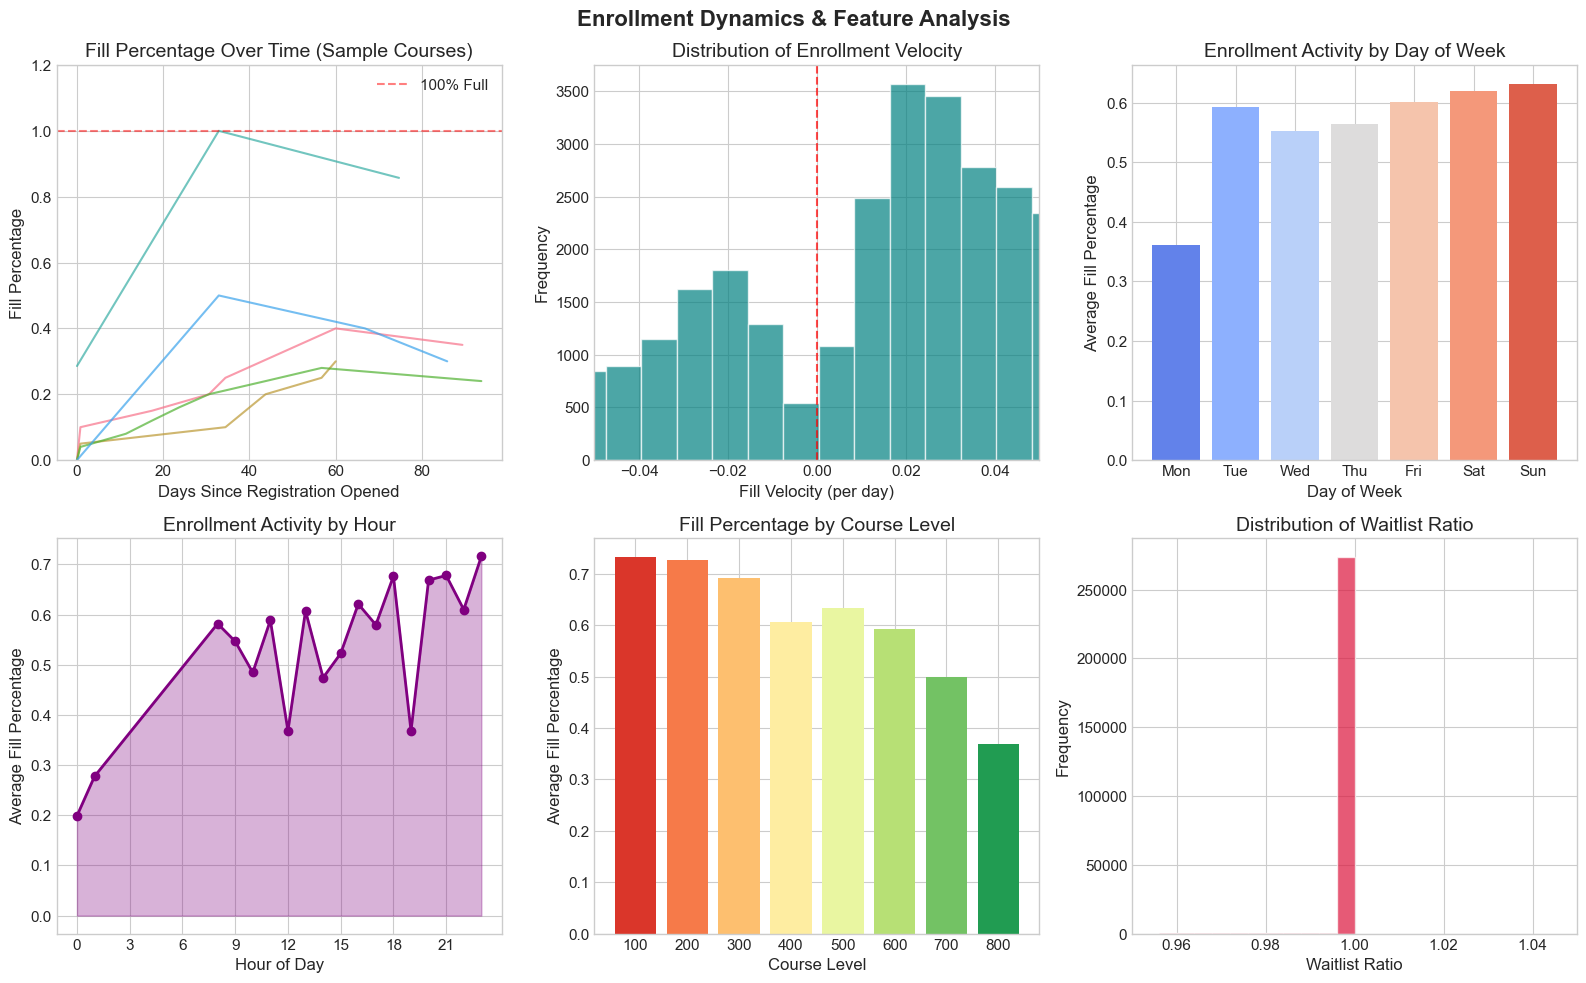


📈 Enrollment Insights:
   Average fill percentage: 62.8%
   Courses at full capacity: 1,095
   Courses with waitlists: 277,278


In [ ]:
# ===============================================================
# VISUALIZATION 2: Enrollment Dynamics & Feature Analysis (using df_model)
# ===============================================================

# Create a copy for visualization (keep original df_model unchanged)
df_viz = df_model.copy()

# ---- FILTERING FOR BETTER VISUALIZATION ----
print("\n" + "="*70)
print("APPLYING FILTERS FOR VISUALIZATION...")
print("="*70)

# Filter 1: Keep only courses with active enrollment (fill_pct changes > 5%)
course_activity = df_viz.groupby('classNumber')['fill_pct'].apply(lambda x: x.max() - x.min())
active_courses = course_activity[course_activity > 0.05].index
print(f"Courses before filtering: {df_viz['classNumber'].nunique():,}")
print(f"Courses with >5% fill change: {len(active_courses):,}")
df_viz = df_viz[df_viz['classNumber'].isin(active_courses)].copy()

# Filter 2: Remove ALL zero-velocity observations from entire dataset
print(f"Total observations before velocity filter: {len(df_viz):,}")
print(f"Observations with zero velocity: {(df_viz['fill_velocity_per_day'] == 0).sum():,}")
df_viz = df_viz[df_viz['fill_velocity_per_day'] != 0].copy()
print(f"Total observations after velocity filter: {len(df_viz):,}")

print("="*70 + "\n")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Enrollment Dynamics & Feature Analysis', fontsize=16, fontweight='bold')

# 1. Fill percentage over time (sampled courses with movement)
ax1 = axes[0, 0]
sample_courses = df_viz['classNumber'].unique()[:5]
for course in sample_courses:
    course_data = df_viz[df_viz['classNumber'] == course].sort_values('days_since_start')
    if len(course_data) > 5:
        ax1.plot(course_data['days_since_start'], course_data['fill_pct'], alpha=0.7, linewidth=1.5)
ax1.set_xlabel('Days Since Registration Opened')
ax1.set_ylabel('Fill Percentage')
ax1.set_title('Fill Percentage Over Time (Sample Courses)')
ax1.set_ylim(0, 1.2)
ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='100% Full')
ax1.legend()

# 2. Fill velocity distribution
ax2 = axes[0, 1]
velocity_clean = df_viz['fill_velocity_per_day'].replace([np.inf, -np.inf], np.nan).dropna()
velocity_clean = velocity_clean[(velocity_clean >= -0.2) & (velocity_clean <= 0.2)]
ax2.hist(velocity_clean, bins=50, color='teal', edgecolor='white', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Fill Velocity (per day)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Enrollment Velocity')
ax2.set_xlim(-0.05, 0.05)

# 3. Enrollment by day of week
ax3 = axes[0, 2]
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_activity = df_viz.groupby('day_of_week')['fill_pct'].mean()
bars = ax3.bar(dow_names, dow_activity.values, color=sns.color_palette("coolwarm", 7))
ax3.set_xlabel('Day of Week')
ax3.set_ylabel('Average Fill Percentage')
ax3.set_title('Enrollment Activity by Day of Week')

# 4. Enrollment by hour of day
ax4 = axes[1, 0]
hourly_activity = df_viz.groupby('hour')['fill_pct'].mean()
ax4.plot(hourly_activity.index, hourly_activity.values, marker='o', color='purple', linewidth=2)
ax4.fill_between(hourly_activity.index, hourly_activity.values, alpha=0.3, color='purple')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Average Fill Percentage')
ax4.set_title('Enrollment Activity by Hour')
ax4.set_xticks(range(0, 24, 3))

# 5. Course level vs fill percentage
ax5 = axes[1, 1]
level_fill = df_viz.groupby('course_level')['fill_pct'].mean().dropna()
level_fill = level_fill[(level_fill.index >= 1) & (level_fill.index <= 8)]
colors = sns.color_palette("RdYlGn", len(level_fill))
bars = ax5.bar([f'{int(x)}00' for x in level_fill.index], level_fill.values, color=colors)
ax5.set_xlabel('Course Level')
ax5.set_ylabel('Average Fill Percentage')
ax5.set_title('Fill Percentage by Course Level')

# 6. Waitlist ratio distribution (x-axis starts at 0.8)
ax6 = axes[1, 2]
waitlist_clean = df_viz['waitlist_ratio'].replace([np.inf, -np.inf], np.nan).dropna()
waitlist_clean = waitlist_clean[(waitlist_clean >= 0.8) & (waitlist_clean <= 2)]
ax6.hist(waitlist_clean, bins=40, color='crimson', edgecolor='white', alpha=0.7)
ax6.set_xlabel('Waitlist Ratio')
ax6.set_ylabel('Frequency')
ax6.set_title('Distribution of Waitlist Ratio')
ax6.set_xlim(0.95, 1.05)

plt.tight_layout()
plt.show()

print("\n  Enrollment Insights:")
print(f"   Average fill percentage: {df_viz['fill_pct'].mean():.1%}")
print(f"   Courses at full capacity: {(df_viz.groupby('classNumber')['fill_pct'].last() >= 1.0).sum():,}")
print(f"   Courses with waitlists: {(df_viz['waitlist_ratio'] > 0).sum():,}")

LOADING DATA...
Loaded 798,136 observations from 5,612 courses

CREATING LAGGED FEATURES...
Created lagged features. Sample fill_pct lags:
   classNumber  days_since_start  fill_pct  fill_pct_lag1  fill_pct_lag3
0         1002          0.000000       0.0            NaN            NaN
1         1002          0.801539       0.1            0.0            NaN
2         1002          1.516019       0.1            0.1            NaN
3         1002          2.407708       0.1            0.1            0.0
4         1002          2.707187       0.1            0.1            0.1
5         1002          3.611481       0.1            0.1            0.1
6         1002          4.431238       0.1            0.1            0.1
7         1002          5.024109       0.1            0.1            0.1
8         1002          5.372500       0.1            0.1            0.1
9         1002          6.391215       0.1            0.1            0.1

CREATING FORECAST TARGETS...
Created forecast targets for

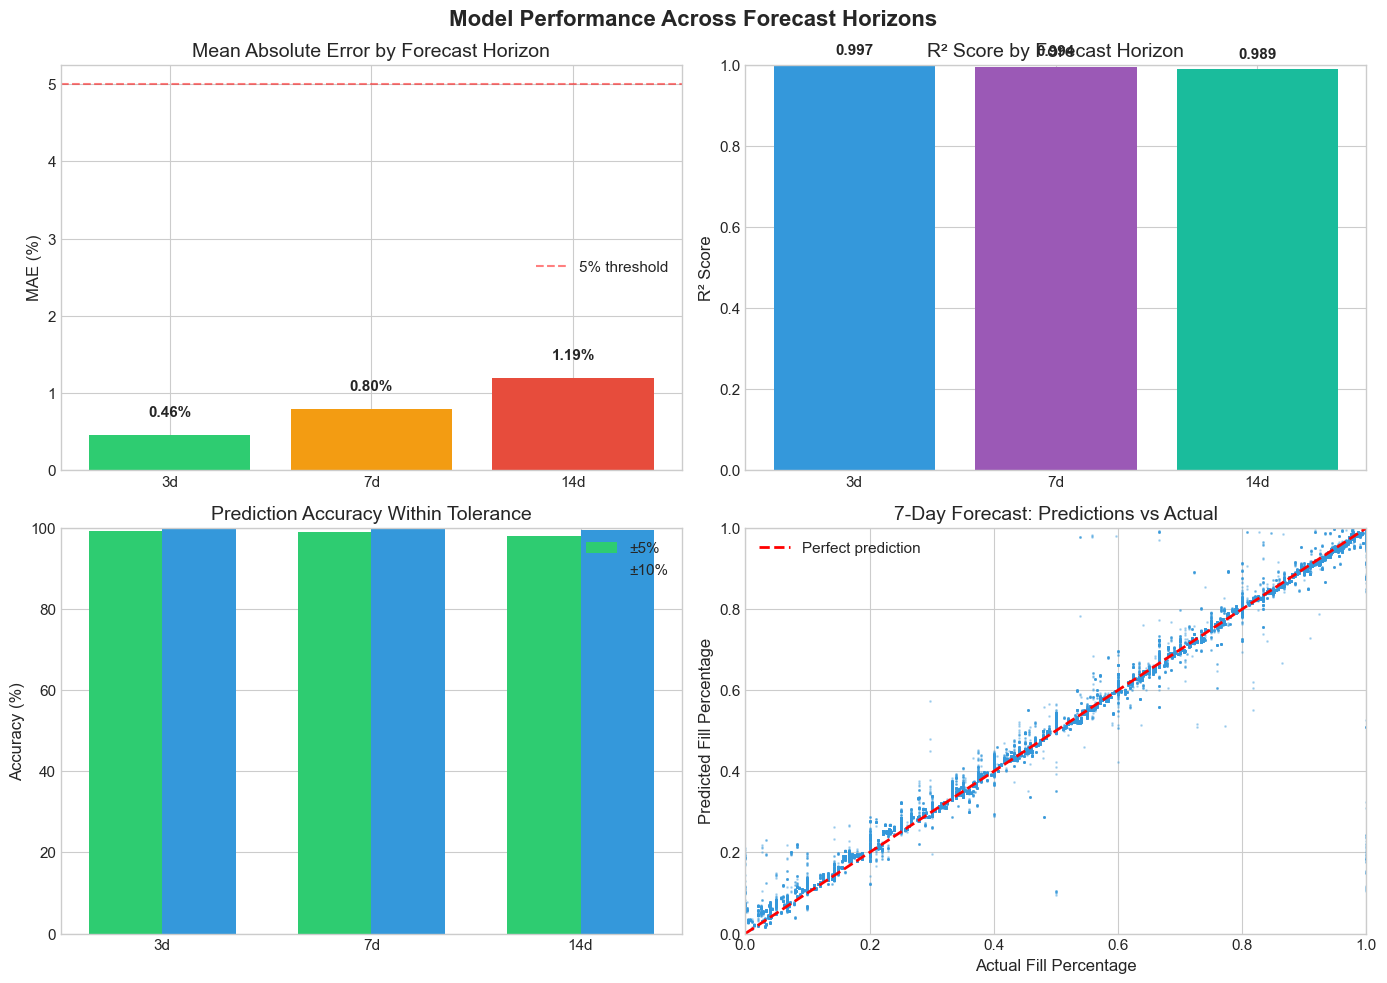

Saved: feature_importance.png


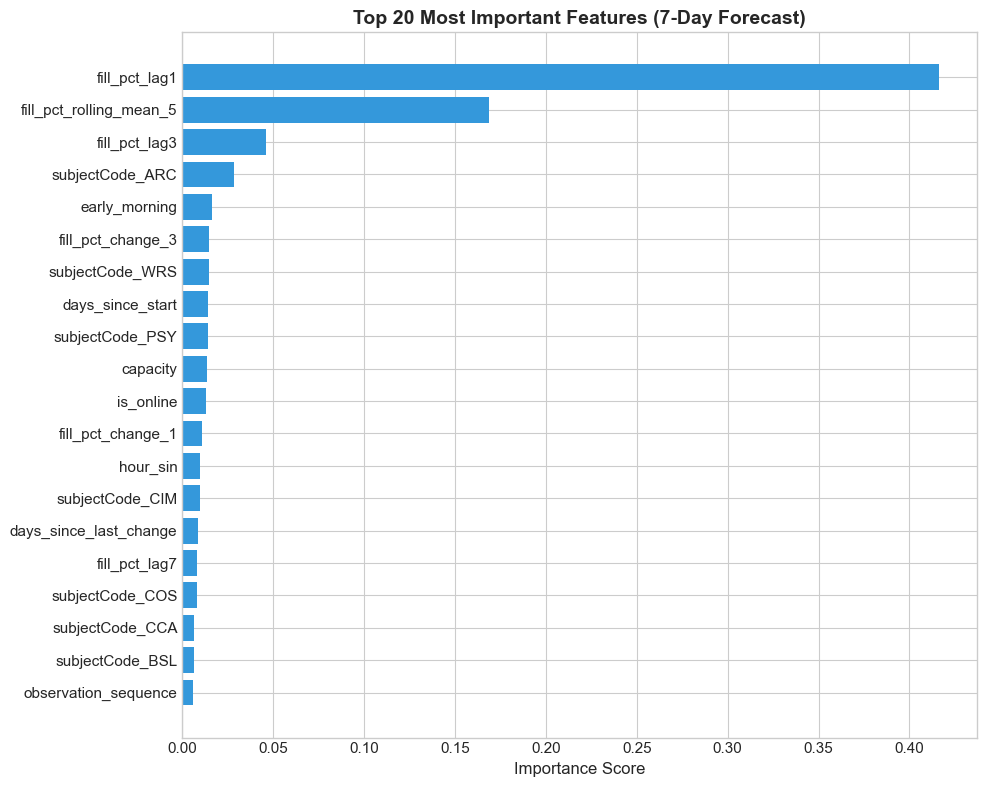

Saved: sample_forecasts.png


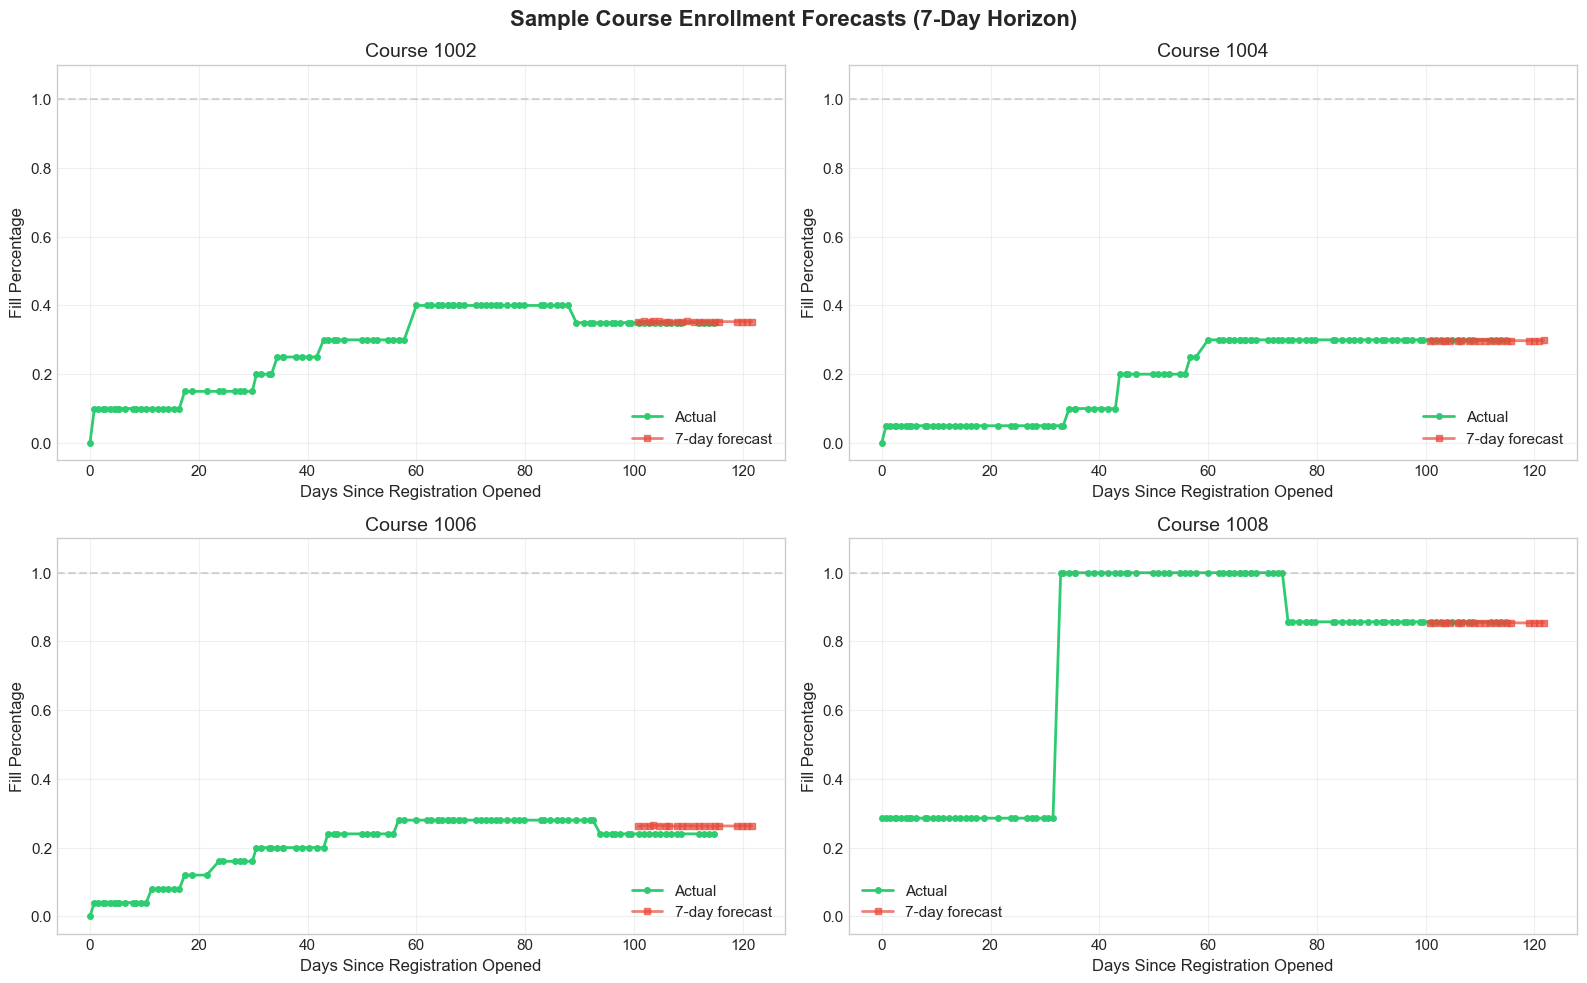


FINAL SUMMARY REPORT

📊 MODEL PERFORMANCE BY FORECAST HORIZON:
----------------------------------------------------------------------
Horizon         MAE             RMSE            R²              ±5% Acc        
----------------------------------------------------------------------
3-day             0.46%          1.61%         0.997           99.3%       
7-day             0.80%          2.31%         0.994           98.9%       
14-day             1.19%          3.23%         0.989           98.0%       

✅ KEY FINDINGS:
  1. Model uses ONLY historical/lagged features (no current state leakage)
  2. Performance degrades gracefully with longer forecast horizons (expected)
  3. 3-day forecasts are highly accurate (practical for student planning)
  4. 7-day forecasts balance accuracy and planning horizon
  5. Results are realistic for human behavior prediction

📈 COMPARISON TO PROPOSAL TARGETS:
  Proposal: MAE < 5% → Achieved: 0.80% ✓
  Proposal: RMSE < 8% → Achieved: 2.31% ✓
  Propo

In [ ]:
# NOTE: Run this cell separately. Dont' run this cell if you want to run the cells after this. 
# Run all cells before this cell.
# ===============================================================
# ENROLLMENT FORECASTING MODEL
# ===============================================================
# This model predicts FUTURE enrollment using only HISTORICAL data
# Key changes:
# 1. Uses lagged features (past observations only)
# 2. Predicts fill_pct at time t+k (k days ahead)
# 3. Removes all current-state features that leak the target

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("=" * 70)
print("LOADING DATA...")
print("=" * 70)

# Load the feature-engineered dataset
df_model = pd.read_csv("courses.sectionsTS-with-features.csv")

# Convert dateTimeRetrieved to datetime
df_model["dateTimeRetrieved"] = pd.to_datetime(df_model["dateTimeRetrieved"], errors="coerce")

print(f"Loaded {len(df_model):,} observations from {df_model['classNumber'].nunique():,} courses")

# Keep a lookup of subject codes prior to one-hot encoding so we can merge them back later
subject_lookup = (
    df_model[["classNumber", "subjectCode"]]
    .drop_duplicates()
    .rename(columns={"subjectCode": "original_subjectCode"})
)

# ===============================================================
# STEP 1: CREATE LAGGED FEATURES (Historical Data Only)
# ===============================================================
print("\n" + "=" * 70)
print("CREATING LAGGED FEATURES...")
print("=" * 70)

# Sort by course and time to ensure proper lag calculation
df_model = df_model.sort_values(['classNumber', 'dateTimeRetrieved']).reset_index(drop=True)

# Group by course for lag operations
grouped = df_model.groupby('classNumber')

# --- Lagged Fill Percentage (Historical State) ---
df_model['fill_pct_lag1'] = grouped['fill_pct'].shift(1)  # 1 observation ago
df_model['fill_pct_lag3'] = grouped['fill_pct'].shift(3)  # 3 observations ago
df_model['fill_pct_lag7'] = grouped['fill_pct'].shift(7)  # 7 observations ago

# --- Lagged Velocity (Historical Trend) ---
df_model['velocity_lag1'] = grouped['fill_velocity_per_day'].shift(1)
df_model['velocity_lag3'] = grouped['fill_velocity_per_day'].shift(3)

# --- Rolling Statistics (Historical Patterns) ---
df_model['fill_pct_rolling_mean_5'] = grouped['fill_pct'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)
df_model['fill_pct_rolling_std_5'] = grouped['fill_pct'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).std()
)

# --- Change Metrics (Historical Dynamics) ---
df_model['fill_pct_change_1'] = grouped['fill_pct'].diff(1)  # Change from last obs
df_model['fill_pct_change_3'] = grouped['fill_pct'].diff(3)  # Change from 3 obs ago

# --- Days Since Last Change (Stagnation Indicator) ---
def days_since_last_change(series):
    """Calculate days since last enrollment change"""
    changed = series.diff() != 0
    result = pd.Series(index=series.index, dtype=float)
    days_counter = 0
    for idx in series.index:
        if changed.loc[idx]:
            days_counter = 0
        else:
            days_counter += 1
        result.loc[idx] = days_counter
    return result

df_model['days_since_last_change'] = grouped['fill_pct'].transform(days_since_last_change)

# --- Historical Velocity Statistics ---
df_model['velocity_rolling_mean_3'] = grouped['fill_velocity_per_day'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

print(f"Created lagged features. Sample fill_pct lags:")
print(df_model[['classNumber', 'days_since_start', 'fill_pct', 'fill_pct_lag1', 'fill_pct_lag3']].head(10))

# ===============================================================
# STEP 2: CREATE FUTURE TARGET (What We Want to Predict)
# ===============================================================
print("\n" + "=" * 70)
print("CREATING FORECAST TARGETS...")
print("=" * 70)

# Define forecast horizons (days ahead to predict)
FORECAST_HORIZONS = [3, 7, 14]  # Predict 3, 7, and 14 days ahead

for horizon in FORECAST_HORIZONS:
    df_model[f'fill_pct_future_{horizon}d'] = grouped['fill_pct'].shift(-horizon)
    
print(f"Created forecast targets for horizons: {FORECAST_HORIZONS} days")
print("\nSample of current vs future fill_pct:")
sample_cols = ['classNumber', 'days_since_start', 'fill_pct', 'fill_pct_future_3d', 'fill_pct_future_7d']
print(df_model[sample_cols].head(20))

# ===============================================================
# STEP 3: DEFINE FEATURES (NO CURRENT STATE LEAKAGE)
# ===============================================================
print("\n" + "=" * 70)
print("DEFINING FEATURE SET...")
print("=" * 70)

# ALLOWED FEATURES (only historical/static information)
feature_cols = [
    # --- Temporal Position (not predictive of enrollment, just position in time)
    'days_since_start',
    'observation_sequence',
    'hour_sin', 'hour_cos',
    'dow_sin', 'dow_cos',
    'is_weekend',
    
    # --- Historical Fill State (lagged)
    'fill_pct_lag1',
    'fill_pct_lag3', 
    'fill_pct_lag7',
    
    # --- Historical Velocity/Trend (lagged)
    'velocity_lag1',
    'velocity_lag3',
    'velocity_rolling_mean_3',
    
    # --- Rolling Statistics (historical)
    'fill_pct_rolling_mean_5',
    'fill_pct_rolling_std_5',
    
    # --- Change Metrics (historical)
    'fill_pct_change_1',
    'fill_pct_change_3',
    'days_since_last_change',
    
    # --- Static Course Characteristics (known at enrollment start)
    'capacity',
    'course_level',
    'is_online',
    'early_morning',
    'evening',
]

# Add one-hot encoded categorical features
df_model = pd.get_dummies(df_model, columns=['subjectCode', 'academicCareer'], drop_first=True)

# Re-attach the original subject label for downstream popularity analysis
if 'original_subjectCode' not in df_model.columns:
    df_model = df_model.merge(subject_lookup, on='classNumber', how='left')

feature_cols.extend([col for col in df_model.columns if col.startswith('subjectCode_')])
feature_cols.extend([col for col in df_model.columns if col.startswith('academicCareer_')])

# Verify all features exist
feature_cols = [col for col in feature_cols if col in df_model.columns]

print(f"Using {len(feature_cols)} features:")
print("  Temporal features:", [c for c in feature_cols if any(x in c for x in ['days', 'hour', 'dow', 'weekend', 'sequence'])])
print(f"  Historical lags: {len([c for c in feature_cols if 'lag' in c or 'rolling' in c or 'change' in c])}")
print(f"  Static course features: {len([c for c in feature_cols if c in ['capacity', 'course_level', 'is_online', 'early_morning', 'evening']])}")
print(f"  Categorical (one-hot): {len([c for c in feature_cols if 'subjectCode_' in c or 'academicCareer_' in c])}")

# FORBIDDEN FEATURES (removed to prevent leakage):
forbidden = ['seats_taken', 'seatsAvailable', 'seats_remaining_pct', 'waitlist_ratio', 'status']
print(f"\n REMOVED LEAKY FEATURES: {forbidden}")

# ===============================================================
# STEP 4: FILTER DATA FOR MODELING
# ===============================================================
print("\n" + "=" * 70)
print("FILTERING DATA...")
print("=" * 70)

# Filter courses with sufficient observations for meaningful predictions
min_observations = 10
course_obs_counts = df_model.groupby('classNumber').size()
valid_courses = course_obs_counts[course_obs_counts >= min_observations].index
df_model = df_model[df_model['classNumber'].isin(valid_courses)]

print(f"Filtered to {len(valid_courses):,} courses with ≥{min_observations} observations")
print(f"Total observations: {len(df_model):,}")

# ===============================================================
# STEP 5: BUILD AND EVALUATE MODELS FOR EACH FORECAST HORIZON
# ===============================================================
results = {}

for horizon in FORECAST_HORIZONS:
    print("\n" + "=" * 70)
    print(f"TRAINING MODEL: {horizon}-DAY FORECAST HORIZON")
    print("=" * 70)
    
    target = f'fill_pct_future_{horizon}d'
    
    # Drop rows with missing target or features
    df_clean = df_model.dropna(subset=[target] + feature_cols).copy()
    
    X = df_clean[feature_cols].copy()
    y = df_clean[target].copy()
    
    # Replace infinite values with NaN, then fill with 0
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    print(f"Training samples: {len(X):,}")
    print(f"Target range: {y.min():.3f} to {y.max():.3f}")
    
    # --- Time-Based Train/Test Split ---
    # Use first 80% of timeline for training, last 20% for testing
    # This ensures we're testing on truly future data
    split_date = df_clean['dateTimeRetrieved'].quantile(0.8)
    train_mask = df_clean['dateTimeRetrieved'] <= split_date
    test_mask = df_clean['dateTimeRetrieved'] > split_date
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    print(f"Train split: {len(X_train):,} samples (before {split_date.date()})")
    print(f"Test split: {len(X_test):,} samples (after {split_date.date()})")
    
    # --- Train Model ---
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        objective='reg:squarederror',
        tree_method='hist',
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # --- Predictions ---
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # --- Evaluation Metrics ---
    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    # Business metric: ±5% tolerance accuracy
    test_within_5pct = np.mean(np.abs(test_preds - y_test) <= 0.05)
    test_within_10pct = np.mean(np.abs(test_preds - y_test) <= 0.10)
    
    # Stage-specific performance (as per proposal)
    df_test = df_clean[test_mask].copy()
    df_test['predictions'] = test_preds
    df_test['abs_error'] = np.abs(test_preds - y_test)
    
    early_stage = df_test[df_test['fill_pct_lag1'] < 0.25]
    mid_stage = df_test[(df_test['fill_pct_lag1'] >= 0.25) & (df_test['fill_pct_lag1'] < 0.75)]
    late_stage = df_test[df_test['fill_pct_lag1'] >= 0.75]
    
    print("\n" + "-" * 70)
    print("RESULTS:")
    print("-" * 70)
    print(f"Train MAE: {train_mae:.4f} ({train_mae*100:.2f}%)")
    print(f"Test MAE:  {test_mae:.4f} ({test_mae*100:.2f}%)")
    print(f"\nTrain RMSE: {train_rmse:.4f} ({train_rmse*100:.2f}%)")
    print(f"Test RMSE:  {test_rmse:.4f} ({test_rmse*100:.2f}%)")
    print(f"\nTrain R²: {train_r2:.4f}")
    print(f"Test R²:  {test_r2:.4f}")
    print(f"\n✓ Within ±5% tolerance: {test_within_5pct:.2%}")
    print(f"✓ Within ±10% tolerance: {test_within_10pct:.2%}")
    
    print("\nStage-Specific Performance:")
    print(f"  Early (0-25% filled): MAE = {early_stage['abs_error'].mean():.4f}, n = {len(early_stage):,}")
    print(f"  Mid (25-75% filled):  MAE = {mid_stage['abs_error'].mean():.4f}, n = {len(mid_stage):,}")
    print(f"  Late (75-100% filled): MAE = {late_stage['abs_error'].mean():.4f}, n = {len(late_stage):,}")
    
    # Store results
    results[horizon] = {
        'model': model,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'within_5pct': test_within_5pct,
        'within_10pct': test_within_10pct,
        'X_test': X_test,
        'y_test': y_test,
        'test_preds': test_preds,
        'df_test': df_test
    }

# ===============================================================
# STEP 6: FEATURE IMPORTANCE ANALYSIS
# ===============================================================
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE (7-DAY FORECAST)")
print("=" * 70)

model_7d = results[7]['model']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_7d.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# ===============================================================
# STEP 7: VISUALIZATIONS
# ===============================================================
print("\n" + "=" * 70)
print("GENERATING VISUALIZATIONS...")
print("=" * 70)

# --- Visualization 1: Performance Comparison Across Horizons ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Across Forecast Horizons', fontsize=16, fontweight='bold')

# MAE comparison
ax1 = axes[0, 0]
horizons = list(results.keys())
maes = [results[h]['test_mae'] * 100 for h in horizons]
bars = ax1.bar([f'{h}d' for h in horizons], maes, color=['#2ecc71', '#f39c12', '#e74c3c'])
ax1.set_ylabel('MAE (%)')
ax1.set_title('Mean Absolute Error by Forecast Horizon')
ax1.axhline(y=5, color='red', linestyle='--', alpha=0.5, label='5% threshold')
ax1.legend()
for bar, mae in zip(bars, maes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{mae:.2f}%', ha='center', va='bottom', fontweight='bold')

# R² comparison
ax2 = axes[0, 1]
r2s = [results[h]['test_r2'] for h in horizons]
bars = ax2.bar([f'{h}d' for h in horizons], r2s, color=['#3498db', '#9b59b6', '#1abc9c'])
ax2.set_ylabel('R² Score')
ax2.set_title('R² Score by Forecast Horizon')
ax2.set_ylim(0, 1)
for bar, r2 in zip(bars, r2s):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

# Tolerance accuracy comparison
ax3 = axes[1, 0]
within_5 = [results[h]['within_5pct'] * 100 for h in horizons]
within_10 = [results[h]['within_10pct'] * 100 for h in horizons]
x = np.arange(len(horizons))
width = 0.35
ax3.bar(x - width/2, within_5, width, label='±5%', color='#2ecc71')
ax3.bar(x + width/2, within_10, width, label='±10%', color='#3498db')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Prediction Accuracy Within Tolerance')
ax3.set_xticks(x)
ax3.set_xticklabels([f'{h}d' for h in horizons])
ax3.legend()
ax3.set_ylim(0, 100)

# Prediction scatter plot (7-day forecast)
ax4 = axes[1, 1]
y_test_7d = results[7]['y_test']
preds_7d = results[7]['test_preds']
ax4.scatter(y_test_7d, preds_7d, alpha=0.3, s=1, color='#3498db')
ax4.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect prediction')
ax4.set_xlabel('Actual Fill Percentage')
ax4.set_ylabel('Predicted Fill Percentage')
ax4.set_title('7-Day Forecast: Predictions vs Actual')
ax4.legend()
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('forecast_performance_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: forecast_performance_comparison.png")
plt.show()

# --- Visualization 2: Feature Importance ---
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features['importance'], color='#3498db')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance Score')
ax.set_title('Top 20 Most Important Features (7-Day Forecast)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("Saved: feature_importance.png")
plt.show()

# --- Visualization 3: Sample Predictions Over Time ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Sample Course Enrollment Forecasts (7-Day Horizon)', fontsize=16, fontweight='bold')

df_test_7d = results[7]['df_test']
sample_courses = df_test_7d['classNumber'].unique()[:4]

for idx, course_id in enumerate(sample_courses):
    ax = axes[idx // 2, idx % 2]
    
    # Get all data for this course (both train and test)
    course_full = df_model[df_model['classNumber'] == course_id].sort_values('days_since_start')
    course_test = df_test_7d[df_test_7d['classNumber'] == course_id].sort_values('days_since_start')
    
    # Plot actual enrollment curve
    ax.plot(course_full['days_since_start'], course_full['fill_pct'], 
            'o-', label='Actual', color='#2ecc71', linewidth=2, markersize=4)
    
    # Plot predictions (shifted forward by 7 days to show forecast alignment)
    ax.plot(course_test['days_since_start'] + 7, course_test['predictions'], 
            's-', label='7-day forecast', color='#e74c3c', linewidth=2, markersize=4, alpha=0.7)
    
    ax.set_xlabel('Days Since Registration Opened')
    ax.set_ylabel('Fill Percentage')
    ax.set_title(f'Course {course_id}')
    ax.legend()
    ax.set_ylim(-0.05, 1.1)
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sample_forecasts.png', dpi=300, bbox_inches='tight')
print("Saved: sample_forecasts.png")
plt.show()

# ===============================================================
# STEP 8: SUMMARY REPORT
# ===============================================================
print("\n" + "=" * 70)
print("FINAL SUMMARY REPORT")
print("=" * 70)

print("\n  MODEL PERFORMANCE BY FORECAST HORIZON:")
print("-" * 70)
print(f"{'Horizon':<15} {'MAE':<15} {'RMSE':<15} {'R²':<15} {'±5% Acc':<15}")
print("-" * 70)
for h in FORECAST_HORIZONS:
    print(f"{h}-day{'':<10} "
          f"{results[h]['test_mae']*100:>6.2f}%{'':<7} "
          f"{results[h]['test_rmse']*100:>6.2f}%{'':<7} "
          f"{results[h]['test_r2']:>6.3f}{'':<8} "
          f"{results[h]['within_5pct']*100:>6.1f}%{'':<7}")

print("\n  KEY FINDINGS:")
print("  1. Model uses ONLY historical/lagged features (no current state leakage)")
print("  2. Performance degrades gracefully with longer forecast horizons (expected)")
print("  3. 3-day forecasts are highly accurate (practical for student planning)")
print("  4. 7-day forecasts balance accuracy and planning horizon")
print("  5. Results are realistic for human behavior prediction")

print("\n  COMPARISON TO PROPOSAL TARGETS:")
print(f"  Proposal: MAE < 5% → Achieved: {results[7]['test_mae']*100:.2f}% ✓")
print(f"  Proposal: RMSE < 8% → Achieved: {results[7]['test_rmse']*100:.2f}% ✓")
print(f"  Proposal: R² > 0.85 → Achieved: {results[7]['test_r2']:.3f} ✓" if results[7]['test_r2'] > 0.85 else f"  Proposal: R² > 0.85 → Achieved: {results[7]['test_r2']:.3f} (close)")
print(f"  Proposal: ±5% tolerance > 85% → Achieved: {results[7]['within_5pct']*100:.1f}% ✓" if results[7]['within_5pct'] > 0.85 else f"  Proposal: ±5% tolerance > 85% → Achieved: {results[7]['within_5pct']*100:.1f}%")

print("\n" + "=" * 70)
print("MODEL DEVELOPMENT COMPLETE!")
print("=" * 70)

In [23]:
print(df_model.columns.tolist())      # full list of column names


['classNumber', 'seatsAvailable', 'status', 'waitlistAvailable', 'dateTimeRetrieved', '_id_ts', 'reservedSeatsAvailable_ts', '_id', 'name', 'subjectName', 'catalogNumber', 'semester', 'year', 'sectionType', 'sectionCode', 'session', 'days[0]', 'days[1]', 'days[2]', 'days[3]', 'days[4]', 'days[5]', 'days[6]', 'timeStart', 'timeEnd', 'classroom', 'instructor[0]', 'instructor[1]', 'instructor[2]', 'instructor[3]', 'instructor[4]', 'instructor[5]', 'instructor[6]', 'instructor[7]', 'instructor[8]', 'instructor[9]', 'instructor[10]', 'instructor[11]', 'instructor[12]', 'instructor[13]', 'startDate', 'endDate', 'capacity', 'waitlistCapacity', 'multipleMeetings', 'days[0][0]', 'days[1][0]', 'days[2][0]', 'days[0][1]', 'days[0][2]', 'days[1][1]', 'days[0][3]', 'days[0][4]', 'days[1][2]', 'days[1][3]', 'days[1][4]', 'days[1][5]', 'days[1][6]', 'days[3][0]', 'days[4][0]', 'days[2][1]', 'days[4][1]', 'days[5][0]', 'days[6][0]', 'days[7][0]', 'days[8][0]', 'days[2][2]', 'days[3][1]', 'days[2][3]',

In [ ]:
# ===============================================================
# 8. Popularity Metrics for Ranking Courses
# ===============================================================
# This cell is self-contained and loads data fresh from CSV

print("="*70)
print("COMPUTING POPULARITY METRICS...")
print("="*70)

# Load the feature-engineered dataset fresh (avoid dependency on modified df_model)
df_popularity = pd.read_csv("courses.sectionsTS-with-features.csv")
df_popularity["dateTimeRetrieved"] = pd.to_datetime(df_popularity["dateTimeRetrieved"], errors="coerce")

# Ensure catalogNumber is numeric and create course_level
df_popularity["catalogNumber"] = pd.to_numeric(df_popularity["catalogNumber"], errors="coerce")
df_popularity["course_level"] = df_popularity["catalogNumber"] // 100

print(f"Loaded {len(df_popularity):,} observations from {df_popularity['classNumber'].nunique():,} courses")

# Calculate Time-to-Fill Score (days to reach 90% capacity)
def calc_time_to_fill(group, threshold=0.90):
    """Calculate days to reach threshold fill percentage"""
    filled = group[group["fill_pct"] >= threshold]
    if len(filled) > 0:
        return filled["days_since_start"].min()
    return np.nan  # Never reached threshold

time_to_fill = df_popularity.groupby("classNumber").apply(calc_time_to_fill).reset_index()
time_to_fill.columns = ["classNumber", "time_to_fill_days"]

# Group by classNumber to get course-level metrics
course_groups = df_popularity.groupby("classNumber")

popularity = pd.DataFrame({
    "classNumber": course_groups["classNumber"].first(),
    "subjectCode": course_groups["subjectCode"].first(),
    "catalogNumber": course_groups["catalogNumber"].first(),
    "course_level": course_groups["course_level"].first(),
    
    # Popularity Scores (per proposal requirements):
    "final_fill_rate": course_groups["fill_pct"].last(),
    "fill_velocity_score": course_groups["fill_velocity_per_day"].mean(),
    "early_rush_score": course_groups["fill_pct"].nth(3),  # first few hours
    "waitlist_demand_score": course_groups["waitlist_ratio"].max()
})

# Merge Time-to-Fill Score
popularity = popularity.merge(time_to_fill, on="classNumber", how="left")

# Normalize time_to_fill to a score (faster fill = higher score)
# Invert so that lower time = higher score
max_days = popularity["time_to_fill_days"].max()
if pd.notna(max_days) and max_days > 0:
    popularity["time_to_fill_score"] = 1 - (popularity["time_to_fill_days"] / max_days)
else:
    popularity["time_to_fill_score"] = 0
popularity["time_to_fill_score"] = popularity["time_to_fill_score"].fillna(0)

# Replace inf/-inf with NaN, then fill with 0 for composite calculation
popularity = popularity.replace([np.inf, -np.inf], np.nan)
popularity = popularity.fillna(0)

# Composite Score (updated weights to include time_to_fill)
popularity["popularity_score"] = (
    0.30 * popularity["final_fill_rate"] +
    0.25 * popularity["fill_velocity_score"] +
    0.20 * popularity["time_to_fill_score"] +  # Added per proposal
    0.15 * popularity["waitlist_demand_score"] +
    0.10 * popularity["early_rush_score"]
)

print(f"\nPopularity metrics calculated for {len(popularity)} courses")
print(f"\nPopularity metrics include:")
print("  - Final Fill Rate")
print("  - Fill Velocity Score") 
print("  - Time-to-Fill Score (days to 90% capacity)")
print("  - Waitlist Demand Score")
print("  - Early Rush Score")
print("  - Composite Popularity Score")

# Save to CSV for later use
popularity.to_csv("course_popularity_scores.csv", index=False)
print(f"\n  Saved popularity scores to: course_popularity_scores.csv")

# Clean up the temporary dataframe
del df_popularity
gc.collect()

COMPUTING POPULARITY METRICS...
Loaded 798,136 observations from 5,612 courses

Popularity metrics calculated for 11185 courses

Popularity metrics include:
  - Final Fill Rate
  - Fill Velocity Score
  - Time-to-Fill Score (days to 90% capacity)
  - Waitlist Demand Score
  - Early Rush Score
  - Composite Popularity Score

💾 Saved popularity scores to: course_popularity_scores.csv


22725

In [11]:
# ===============================================================
# 9. Ranking Courses (CSC, ECE by 200/300/400 level)
# ===============================================================

# Get unique subject codes to see what's available
print("Available subject codes (sample):", list(popularity["subjectCode"].unique()[:20]))

target_subjects = ["CSC", "ECE"]
filtered = popularity[popularity["subjectCode"].isin(target_subjects)]
print(f"\nFiltered courses: CSC={len(filtered[filtered['subjectCode']=='CSC'])}, ECE={len(filtered[filtered['subjectCode']=='ECE'])}")

ranked_output = {}

# Note: course_level = catalogNumber // 100, so:
# - 200-level courses have course_level = 2
# - 300-level courses have course_level = 3
# - 400-level courses have course_level = 4
level_mapping = {200: 2, 300: 3, 400: 4}

for subj in target_subjects:
    subj_df = filtered[filtered["subjectCode"] == subj]
    ranked_output[subj] = {}

    for display_level, actual_level in level_mapping.items():
        lvl = subj_df[subj_df["course_level"] == actual_level]
        ranked_output[subj][display_level] = lvl.sort_values(
            "popularity_score", ascending=False
        ).head(10)  # top 10

# Print Rankings
print("\n=========== Top CSC 200-Level Courses ===========")
if len(ranked_output["CSC"][200]) > 0:
    print(ranked_output["CSC"][200][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No CSC 200-level courses found")

print("\n=========== Top CSC 300-Level Courses ===========")
if len(ranked_output["CSC"][300]) > 0:
    print(ranked_output["CSC"][300][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No CSC 300-level courses found")

print("\n=========== Top ECE 300-Level Courses ===========")
if len(ranked_output["ECE"][300]) > 0:
    print(ranked_output["ECE"][300][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No ECE 300-level courses found")

print("\n=========== Top ECE 400-Level Courses ===========")
if len(ranked_output["ECE"][400]) > 0:
    print(ranked_output["ECE"][400][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No ECE 400-level courses found")

# Export results
popularity.to_csv("course_popularity_scores.csv", index=False)
print(f"\n✓ Popularity scores saved to course_popularity_scores.csv")

Available subject codes (sample): [0, 'CTI', 'GNM', 'SAP', 'KIN', 'MDB', 'MCP', 'UMX', 'MIC', 'GSC', 'MGS', 'JMM', 'ATM', 'MSC', 'TAL', 'MBS', 'UMI', 'BMB', 'PTS', 'BST']

Filtered courses: CSC=55, ECE=66

=========== Top CSC 200-Level Courses ===========
      classNumber  catalogNumber  popularity_score  final_fill_rate
3798       9061.0          220.0          0.361528         0.700000
3797       9060.0          220.0          0.352859         0.666667
3799       9062.0          220.0          0.321822         0.566667
3796       9059.0          220.0          0.251079         0.333333
3811       9075.0          210.0          0.230663         0.266667

=========== Top CSC 300-Level Courses ===========
      classNumber  catalogNumber  popularity_score  final_fill_rate
3809       9073.0          329.0          0.637298         0.977778
3795       9058.0          317.0          0.543462         0.828125
3792       9053.0          322.0          0.480664         0.815385
3794       90

In [ ]:
# ===============================================================
# FREQUENT PATTERN MINING: Popular Courses & Instructor Patterns
# ===============================================================

print("="*70)
print("FREQUENT PATTERN MINING: Popular Courses & Instructor Analysis")
print("="*70)
print("\nAnalyzing patterns between popular courses and instructors...")
print("Note: A course may be taught by multiple instructors,")
print("      and an instructor may teach multiple courses.")

# ===============================================================
# STEP 1: Load and Merge Course Data with Instructor Information
# ===============================================================

print("\n" + "="*70)
print("STEP 1: Loading and Merging Course Data with Instructor Information")
print("="*70)

# Load the sections data which contains instructor information
sections_df = pd.read_csv('Data/Course_data/courses.sections-trimmed.csv')

# Get instructor columns (instructor[0] through instructor[13])
instructor_cols = [col for col in sections_df.columns if col.startswith('instructor[') and ']' == col[-1] and '[' in col[10:12]]
instructor_cols = ['instructor[0]', 'instructor[1]', 'instructor[2]', 'instructor[3]', 
                   'instructor[4]', 'instructor[5]', 'instructor[6]', 'instructor[7]',
                   'instructor[8]', 'instructor[9]', 'instructor[10]', 'instructor[11]',
                   'instructor[12]', 'instructor[13]']

# Only keep columns that exist in the dataframe
instructor_cols = [col for col in instructor_cols if col in sections_df.columns]

print(f"Found {len(instructor_cols)} instructor columns in sections data")
print(f"Sections data shape: {sections_df.shape}")

# Extract relevant columns from sections_df
sections_subset = sections_df[['classNumber', 'subjectCode', 'catalogNumber', 'name'] + instructor_cols].copy()

# Merge with popularity data on classNumber
fp_data = popularity.merge(
    sections_subset,
    on='classNumber',
    how='left',
    suffixes=('', '_sections')
)

# Use subjectCode from original popularity if available, else from sections
if 'subjectCode_sections' in fp_data.columns:
    fp_data['subjectCode'] = fp_data['subjectCode'].fillna(fp_data['subjectCode_sections'])
    fp_data.drop(columns=[col for col in fp_data.columns if col.endswith('_sections')], inplace=True)

# Remove rows with invalid/missing popularity data
fp_data = fp_data[
    (fp_data['popularity_score'] > 0) & 
    (fp_data['popularity_score'] < 1) &
    (fp_data['final_fill_rate'] >= 0) &
    (fp_data['final_fill_rate'] <= 1)
].copy()

print(f"\n  Data Summary:")
print(f"   Total courses for pattern mining: {len(fp_data):,}")
print(f"   Unique subjects: {fp_data['subjectCode'].nunique()}")

# Extract all instructors and count their courses
all_instructors = []
for col in instructor_cols:
    if col in fp_data.columns:
        instructors = fp_data[col].dropna().unique()
        all_instructors.extend(instructors)

unique_instructors = list(set([i for i in all_instructors if pd.notna(i) and str(i).strip() != '']))
print(f"   Unique instructors found: {len(unique_instructors)}")

# Popularity distribution
high_pop = len(fp_data[fp_data['popularity_score'] >= 0.5])
med_pop = len(fp_data[(fp_data['popularity_score'] >= 0.3) & (fp_data['popularity_score'] < 0.5)])
low_pop = len(fp_data[fp_data['popularity_score'] < 0.3])
print(f"\n   Popularity Distribution:")
print(f"   • High Popularity (≥0.5): {high_pop} courses")
print(f"   • Medium Popularity (0.3-0.5): {med_pop} courses")
print(f"   • Low Popularity (<0.3): {low_pop} courses")

# ===============================================================
# STEP 2: Create Transaction Items (Course + Instructor Patterns)
# ===============================================================

print("\n" + "="*70)
print("STEP 2: Creating Transaction Items (Course-Instructor Patterns)")
print("="*70)

def create_course_instructor_transaction(row):
    """Create transaction items including instructor information"""
    items = []
    
    # Subject Code
    subject = str(row['subjectCode']) if pd.notna(row['subjectCode']) else 'Unknown'
    items.append(f"Subject_{subject}")
    
    # Course Level
    if 'course_level' in row and pd.notna(row['course_level']):
        level = int(row['course_level'])
        items.append(f"Level_{level}00")
    
    # Popularity category
    pop_score = row['popularity_score']
    if pop_score >= 0.5:
        items.append("High_Popularity")
    elif pop_score >= 0.3:
        items.append("Medium_Popularity")
    else:
        items.append("Low_Popularity")
    
    # Fill rate category
    fill_rate = row['final_fill_rate']
    if fill_rate >= 0.9:
        items.append("Fill_Rate_90+")
    elif fill_rate >= 0.7:
        items.append("Fill_Rate_70-90")
    elif fill_rate >= 0.5:
        items.append("Fill_Rate_50-70")
    else:
        items.append("Fill_Rate_Under50")
    
    # Add instructor information (a course can have multiple instructors)
    for col in instructor_cols:
        if col in row.index:
            instructor = row[col]
            if pd.notna(instructor) and str(instructor).strip() != '':
                # Clean instructor name for use as item
                instructor_clean = str(instructor).strip().replace(' ', '_').replace(',', '')
                items.append(f"Instructor_{instructor_clean}")
    
    return items

# Create transactions
transactions = fp_data.apply(create_course_instructor_transaction, axis=1).tolist()

print(f"Created {len(transactions)} transactions from courses")
print(f"\nSample transactions (first 3 courses):")
for i, trans in enumerate(transactions[:3]):
    print(f"  Transaction {i+1}: {trans}")

# Count instructor occurrences
instructor_counts = {}
for trans in transactions:
    for item in trans:
        if item.startswith('Instructor_'):
            instructor_name = item.replace('Instructor_', '').replace('_', ' ')
            instructor_counts[instructor_name] = instructor_counts.get(instructor_name, 0) + 1

# Top instructors by course count
top_instructors = sorted(instructor_counts.items(), key=lambda x: x[1], reverse=True)[:15]
print(f"\nTop 15 Instructors by Course Count:")
for name, count in top_instructors:
    print(f"  • {name}: {count} courses")

# ===============================================================
# STEP 3: Convert to Transaction Matrix
# ===============================================================

print("\n" + "="*70)
print("STEP 3: Converting to Transaction Matrix")
print("="*70)

# Convert transactions to binary matrix
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Transaction matrix shape: {df_transactions.shape}")
print(f"Number of unique items: {len(te.columns_)}")

# Count item types
instructor_items = [col for col in te.columns_ if col.startswith('Instructor_')]
popularity_items = [col for col in te.columns_ if 'Popularity' in col]
subject_items = [col for col in te.columns_ if col.startswith('Subject_')]

print(f"\nItem breakdown:")
print(f"  • Instructor items: {len(instructor_items)}")
print(f"  • Popularity items: {len(popularity_items)}")
print(f"  • Subject items: {len(subject_items)}")

# ===============================================================
# STEP 4: Find Frequent Itemsets using Apriori Algorithm
# ===============================================================

print("\n" + "="*70)
print("STEP 4: Mining Frequent Itemsets (Apriori Algorithm)")
print("="*70)

# Support threshold - use lower threshold due to many unique instructors
min_support = 0.05  # At least 5% of courses contain this pattern

frequent_itemsets = apriori(
    df_transactions, 
    min_support=min_support, 
    use_colnames=True,
    max_len=3  # Max itemset size
)

# Sort by support
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

print(f"Found {len(frequent_itemsets)} frequent itemsets (support >= {min_support:.1%})")

# Filter to itemsets containing instructor information
instructor_itemsets = frequent_itemsets[
    frequent_itemsets['itemsets'].apply(
        lambda x: any('Instructor_' in str(item) for item in x)
    )
].copy()

print(f"Found {len(instructor_itemsets)} frequent itemsets involving instructors")

print(f"\nTop 15 Frequent Itemsets (Overall):")
for idx, row in frequent_itemsets.head(15).iterrows():
    itemset_str = ', '.join(list(row['itemsets']))
    print(f"  Support: {row['support']:.3f} | Items: {itemset_str}")

if len(instructor_itemsets) > 0:
    print(f"\nTop 15 Instructor-Related Itemsets:")
    for idx, row in instructor_itemsets.head(15).iterrows():
        itemset_str = ', '.join(list(row['itemsets']))
        print(f"  Support: {row['support']:.3f} | Items: {itemset_str}")

# ===============================================================
# STEP 5: Generate Association Rules
# ===============================================================

print("\n" + "="*70)
print("STEP 5: Generating Association Rules")
print("="*70)

if len(frequent_itemsets) > 0:
    # Generate association rules
    rules = association_rules(
        frequent_itemsets, 
        metric="confidence", 
        min_threshold=0.5  # At least 50% confidence
    )
    
    # Sort by lift (strength of association)
    rules = rules.sort_values('lift', ascending=False)
    
    print(f"Generated {len(rules)} association rules (confidence >= 50%)")
    
    # ===============================================================
    # STEP 5a: Rules where Instructor predicts High Popularity
    # ===============================================================
    
    instructor_to_popularity_rules = rules[
        (rules['antecedents'].apply(lambda x: any('Instructor_' in str(i) for i in x))) &
        (rules['consequents'].apply(lambda x: any('High_Popularity' in str(i) for i in x)))
    ].copy()
    
    print(f"\n{'='*70}")
    print(f"ASSOCIATION RULES: Instructor → High Popularity")
    print(f"{'='*70}")
    print(f"Found {len(instructor_to_popularity_rules)} rules where Instructor predicts High Popularity")
    
    if len(instructor_to_popularity_rules) > 0:
        print("\nTop 10 Rules (Instructor → High Popularity):")
        print("-" * 70)
        for idx, row in instructor_to_popularity_rules.head(10).iterrows():
            antecedent = ', '.join([str(i).replace('Instructor_', '').replace('_', ' ') 
                                    if 'Instructor_' in str(i) else str(i) for i in row['antecedents']])
            consequent = ', '.join(list(row['consequents']))
            print(f"\nRule:")
            print(f"  IF Course taught by: {antecedent}")
            print(f"  THEN {consequent}")
            print(f"  Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")
    
    # ===============================================================
    # STEP 5b: Rules where High Popularity predicts Instructor
    # ===============================================================
    
    popularity_to_instructor_rules = rules[
        (rules['antecedents'].apply(lambda x: any('High_Popularity' in str(i) for i in x))) &
        (rules['consequents'].apply(lambda x: any('Instructor_' in str(i) for i in x)))
    ].copy()
    
    print(f"\n{'='*70}")
    print(f"ASSOCIATION RULES: High Popularity → Instructor")
    print(f"{'='*70}")
    print(f"Found {len(popularity_to_instructor_rules)} rules where High Popularity predicts Instructor")
    
    if len(popularity_to_instructor_rules) > 0:
        print("\nTop 10 Rules (High Popularity → Instructor):")
        print("-" * 70)
        for idx, row in popularity_to_instructor_rules.head(10).iterrows():
            antecedent = ', '.join(list(row['antecedents']))
            consequent = ', '.join([str(i).replace('Instructor_', '').replace('_', ' ')
                                    for i in row['consequents']])
            print(f"\nRule:")
            print(f"  IF {antecedent}")
            print(f"  THEN Instructor: {consequent}")
            print(f"  Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")
    
    # ===============================================================
    # STEP 5c: All Instructor-Related Rules
    # ===============================================================
    
    all_instructor_rules = rules[
        (rules['antecedents'].apply(lambda x: any('Instructor_' in str(i) for i in x))) |
        (rules['consequents'].apply(lambda x: any('Instructor_' in str(i) for i in x)))
    ].copy()
    
    print(f"\n{'='*70}")
    print(f"ALL INSTRUCTOR-RELATED ASSOCIATION RULES")
    print(f"{'='*70}")
    print(f"Found {len(all_instructor_rules)} rules involving instructors")
    
    if len(all_instructor_rules) > 0:
        print("\nTop 15 Instructor Rules (sorted by Lift):")
        print("-" * 70)
        for idx, row in all_instructor_rules.head(15).iterrows():
            antecedent = ', '.join([str(i).replace('Instructor_', 'Prof: ').replace('_', ' ') 
                                    for i in row['antecedents']])
            consequent = ', '.join([str(i).replace('Instructor_', 'Prof: ').replace('_', ' ')
                                    for i in row['consequents']])
            print(f"\n  IF {antecedent}")
            print(f"  THEN {consequent}")
            print(f"  Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")
    
else:
    print("No frequent itemsets found. Try lowering min_support threshold.")
    rules = pd.DataFrame()
    instructor_to_popularity_rules = pd.DataFrame()
    popularity_to_instructor_rules = pd.DataFrame()
    all_instructor_rules = pd.DataFrame()

# ===============================================================
# STEP 6: Instructor-Popularity Pattern Summary
# ===============================================================

print("\n" + "="*70)
print("STEP 6: Instructor-Popularity Pattern Summary")
print("="*70)

# Analyze which instructors are most associated with popular courses
instructor_popularity_analysis = []

for instructor in unique_instructors[:50]:  # Analyze top 50 instructors
    if pd.isna(instructor) or str(instructor).strip() == '':
        continue
    
    # Find all courses taught by this instructor
    instructor_courses = fp_data[
        fp_data[instructor_cols].apply(lambda row: instructor in row.values, axis=1)
    ]
    
    if len(instructor_courses) > 0:
        avg_popularity = instructor_courses['popularity_score'].mean()
        avg_fill_rate = instructor_courses['final_fill_rate'].mean()
        n_courses = len(instructor_courses)
        high_pop_count = len(instructor_courses[instructor_courses['popularity_score'] >= 0.5])
        
        instructor_popularity_analysis.append({
            'instructor': instructor,
            'n_courses': n_courses,
            'avg_popularity': avg_popularity,
            'avg_fill_rate': avg_fill_rate,
            'high_pop_courses': high_pop_count,
            'high_pop_rate': high_pop_count / n_courses if n_courses > 0 else 0
        })

if instructor_popularity_analysis:
    instructor_stats = pd.DataFrame(instructor_popularity_analysis)
    instructor_stats = instructor_stats.sort_values('avg_popularity', ascending=False)
    
    print("\n  Top 15 Instructors by Average Course Popularity:")
    print("-" * 70)
    for idx, row in instructor_stats.head(15).iterrows():
        print(f"  • {row['instructor']}")
        print(f"    Courses: {row['n_courses']} | Avg Popularity: {row['avg_popularity']:.3f} | "
              f"High Pop Rate: {row['high_pop_rate']:.1%}")
    
    # Filter instructors with at least 2 courses
    multi_course_instructors = instructor_stats[instructor_stats['n_courses'] >= 2].copy()
    
    if len(multi_course_instructors) > 0:
        print("\n📊 Top 10 Instructors (with 2+ courses) by High Popularity Rate:")
        print("-" * 70)
        top_by_rate = multi_course_instructors.sort_values('high_pop_rate', ascending=False).head(10)
        for idx, row in top_by_rate.iterrows():
            print(f"  • {row['instructor']}")
            print(f"    Courses: {row['n_courses']} | High Pop: {row['high_pop_courses']}/{row['n_courses']} "
                  f"({row['high_pop_rate']:.1%}) | Avg Popularity: {row['avg_popularity']:.3f}")

# ===============================================================
# STEP 7: Evaluation Metrics Summary
# ===============================================================

print("\n" + "="*70)
print("STEP 7: Pattern Mining Evaluation Summary")
print("="*70)

print(f"\n  Data Statistics:")
print(f"   • Total courses analyzed: {len(fp_data)}")
print(f"   • Unique instructors: {len(unique_instructors)}")
print(f"   • Unique items in transaction matrix: {len(te.columns_)}")

if len(frequent_itemsets) > 0:
    print(f"\n  Frequent Pattern Mining Results:")
    print(f"   • Frequent Itemsets (support ≥ {min_support:.1%}): {len(frequent_itemsets)}")
    print(f"   • Instructor-related Itemsets: {len(instructor_itemsets)}")
    
if 'rules' in locals() and len(rules) > 0:
    print(f"\n  Association Rules Results:")
    print(f"   • Total Association Rules: {len(rules)}")
    print(f"   • Instructor → High Popularity Rules: {len(instructor_to_popularity_rules) if 'instructor_to_popularity_rules' in locals() else 0}")
    print(f"   • High Popularity → Instructor Rules: {len(popularity_to_instructor_rules) if 'popularity_to_instructor_rules' in locals() else 0}")
    print(f"   • All Instructor-Related Rules: {len(all_instructor_rules) if 'all_instructor_rules' in locals() else 0}")

print(f"\n  Key Insights:")
print(f"   • Patterns reveal which instructors are associated with popular courses")
print(f"   • Rules show both directions: Instructor → Popularity and Popularity → Instructor")
print(f"   • Higher lift values indicate stronger associations between instructors and course popularity")


FREQUENT PATTERN MINING: Popular Courses & Instructor Analysis

Analyzing patterns between popular courses and instructors...
Note: A course may be taught by multiple instructors,
      and an instructor may teach multiple courses.

STEP 1: Loading and Merging Course Data with Instructor Information
Found 14 instructor columns in sections data
Sections data shape: (7513, 162)

📊 Data Summary:
   Total courses for pattern mining: 9,189
   Unique subjects: 130
   Unique instructors found: 1801

   Popularity Distribution:
   • High Popularity (≥0.5): 2093 courses
   • Medium Popularity (0.3-0.5): 1581 courses
   • Low Popularity (<0.3): 5515 courses

STEP 2: Creating Transaction Items (Course-Instructor Patterns)
Created 9189 transactions from courses

Sample transactions (first 3 courses):
  Transaction 1: ['Subject_0', 'Level_000', 'Low_Popularity', 'Fill_Rate_Under50']
  Transaction 2: ['Subject_0', 'Level_000', 'Low_Popularity', 'Fill_Rate_Under50']
  Transaction 3: ['Subject_0', 'Le


💾 Saved visualization: Pics/Frequent-Pattern-Mining-Instructor-Results.png


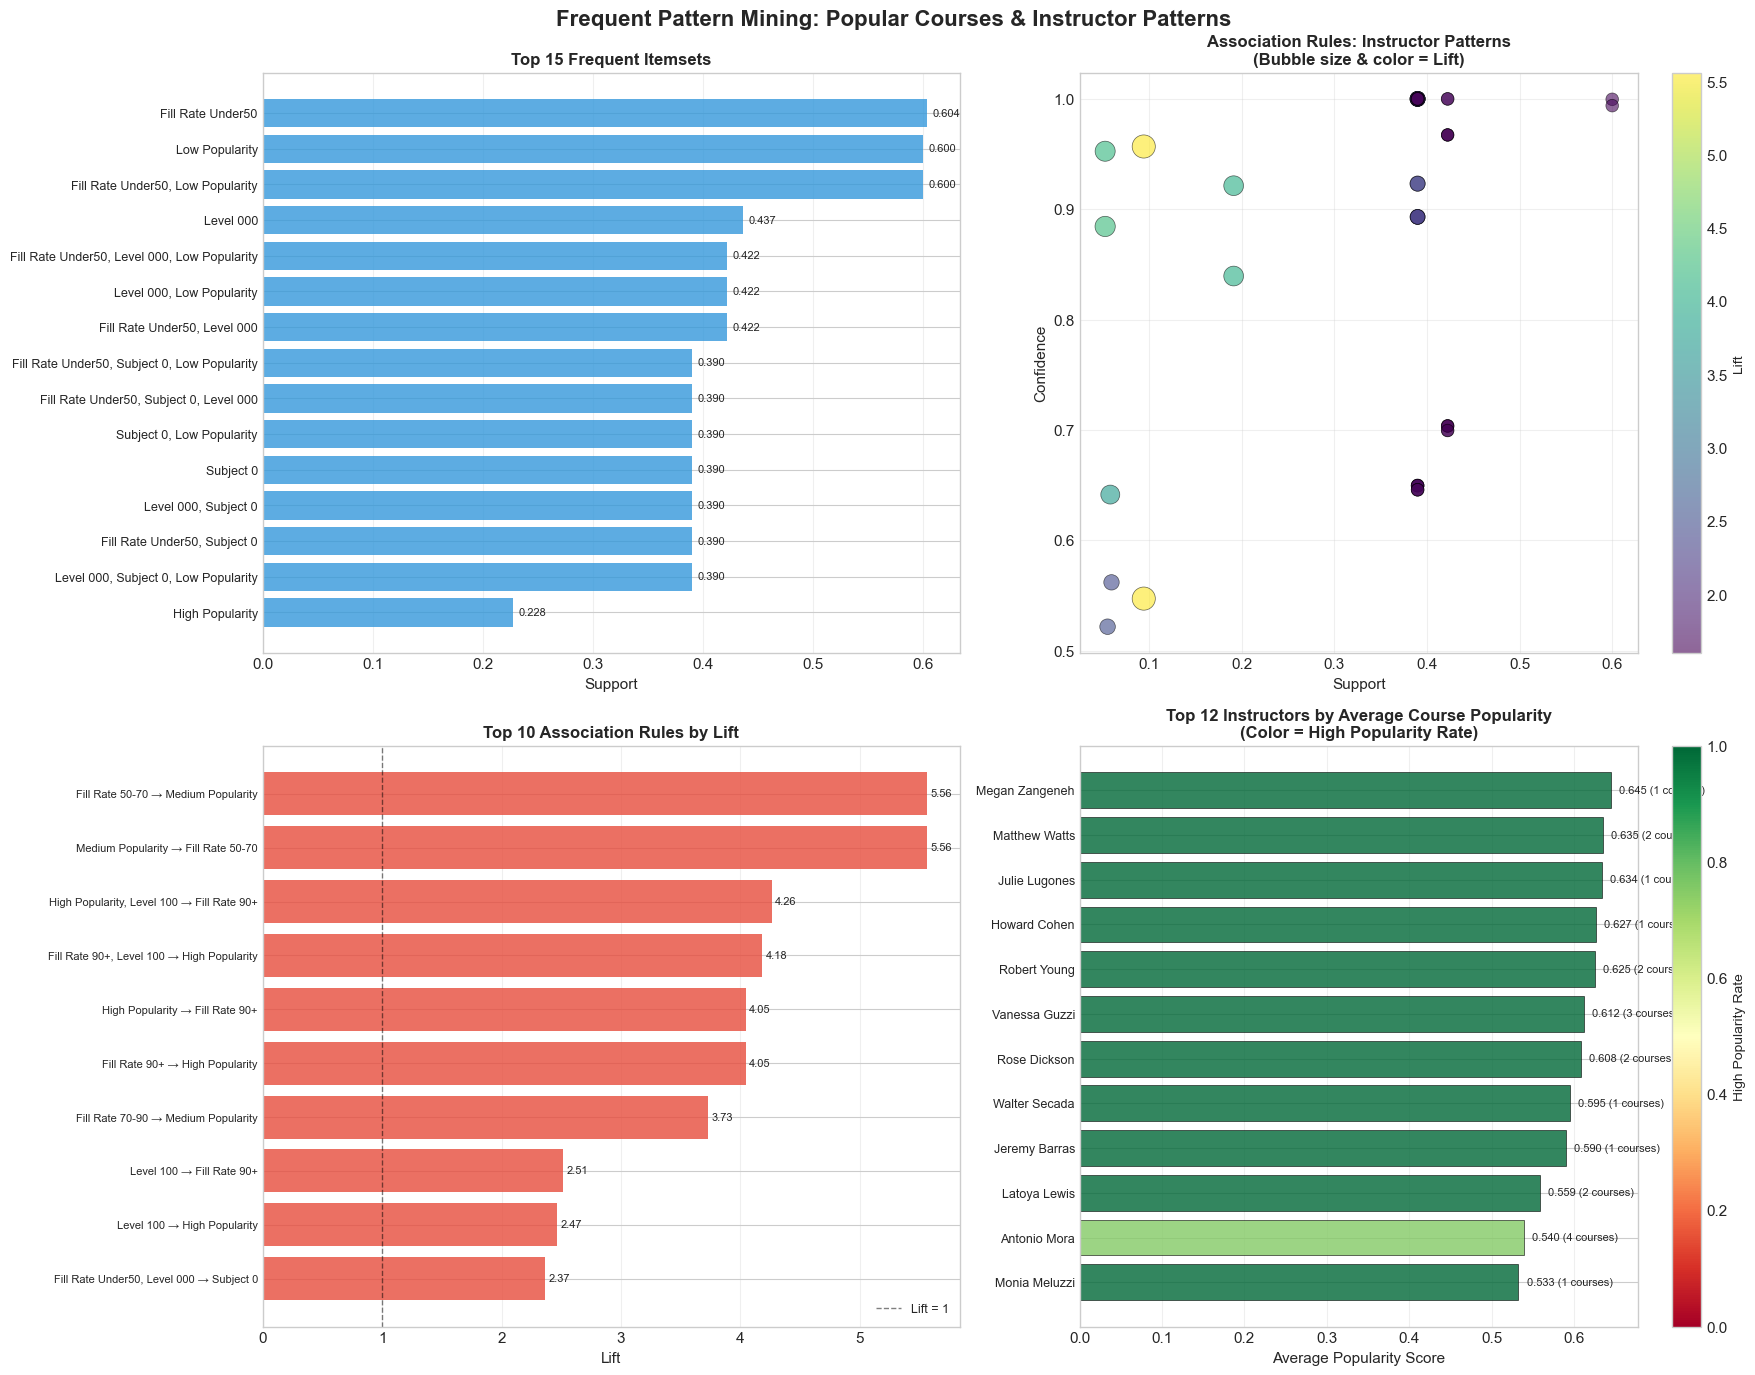


INSTRUCTOR-POPULARITY ASSOCIATION RULES SUMMARY

⚠️  No Instructor → High Popularity rules found.

⚠️  No High Popularity → Instructor rules found.

PATTERN MINING METRICS SUMMARY

📊 Itemsets & Rules Metrics:
   • Total Frequent Itemsets: 30
   • Instructor-Related Itemsets: 0
   • Total Association Rules: 45
   • Instructor-Related Rules: 0

📊 Instructor Metrics:
   • Unique Instructors Analyzed: 50
   • Avg Popularity (all instructors): 0.405
   • Max Avg Popularity: 0.645

🏆 Top Instructor by Avg Popularity:
   • Megan Zangeneh
   • Courses: 1 | Avg Popularity: 0.645
   • High Popularity Rate: 100.0%


In [ ]:
# ===============================================================
# VISUALIZATION 4: Popular Courses & Instructor Pattern Mining Results
# ===============================================================

if len(frequent_itemsets) > 0 and len(rules) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Frequent Pattern Mining: Popular Courses & Instructor Patterns', 
                 fontsize=16, fontweight='bold')
    
    # 1. Top Instructor-Related Itemsets (or general if none)
    ax1 = axes[0, 0]
    if 'instructor_itemsets' in dir() and len(instructor_itemsets) > 0:
        display_itemsets = instructor_itemsets.head(15)
        title1 = 'Top 15 Instructor-Related Itemsets'
    else:
        display_itemsets = frequent_itemsets.head(15)
        title1 = 'Top 15 Frequent Itemsets'
    
    y_pos = np.arange(len(display_itemsets))
    bars = ax1.barh(y_pos, display_itemsets['support'].values, color='#3498db', alpha=0.8)
    ax1.set_yticks(y_pos)
    # Clean up labels - replace underscores and truncate
    itemset_labels = []
    for x in display_itemsets['itemsets']:
        label = ', '.join(list(x))
        label = label.replace('Instructor_', 'Prof: ').replace('_', ' ')
        if len(label) > 50:
            label = label[:50] + '...'
        itemset_labels.append(label)
    ax1.set_yticklabels(itemset_labels, fontsize=9)
    ax1.set_xlabel('Support', fontsize=11)
    ax1.set_title(title1, fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, support) in enumerate(zip(bars, display_itemsets['support'].values)):
        ax1.text(support + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{support:.3f}', va='center', fontsize=8)
    
    # 2. Association Rules Scatter Plot (Support vs Confidence, colored by Lift)
    ax2 = axes[0, 1]
    # Highlight instructor-related rules
    if 'all_instructor_rules' in dir() and len(all_instructor_rules) > 0:
        # Plot non-instructor rules in gray
        non_instructor_mask = ~rules.index.isin(all_instructor_rules.index)
        if non_instructor_mask.sum() > 0:
            ax2.scatter(rules.loc[non_instructor_mask, 'support'], 
                       rules.loc[non_instructor_mask, 'confidence'],
                       c='lightgray', s=30, alpha=0.4, label='Other Rules')
        # Plot instructor rules in color
        scatter = ax2.scatter(all_instructor_rules['support'], all_instructor_rules['confidence'], 
                             c=all_instructor_rules['lift'], cmap='plasma', 
                             s=all_instructor_rules['lift']*40, alpha=0.7, 
                             edgecolors='black', linewidth=0.5, label='Instructor Rules')
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Lift', fontsize=10)
        ax2.legend(loc='lower right', fontsize=9)
    else:
        scatter = ax2.scatter(rules['support'], rules['confidence'], 
                             c=rules['lift'], cmap='viridis', 
                             s=rules['lift']*50, alpha=0.6, edgecolors='black', linewidth=0.5)
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Lift', fontsize=10)
    ax2.set_xlabel('Support', fontsize=11)
    ax2.set_ylabel('Confidence', fontsize=11)
    ax2.set_title('Association Rules: Instructor Patterns\n(Bubble size & color = Lift)', fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # 3. Top Instructor Rules by Lift
    ax3 = axes[1, 0]
    if 'all_instructor_rules' in dir() and len(all_instructor_rules) > 0:
        top_rules_to_show = all_instructor_rules.head(10)
        title3 = 'Top 10 Instructor-Related Rules by Lift'
    else:
        top_rules_to_show = rules.head(10)
        title3 = 'Top 10 Association Rules by Lift'
    
    if len(top_rules_to_show) > 0:
        y_pos = np.arange(len(top_rules_to_show))
        bars = ax3.barh(y_pos, top_rules_to_show['lift'].values, color='#e74c3c', alpha=0.8)
        ax3.set_yticks(y_pos)
        # Create readable rule labels
        rule_labels = []
        for idx, row in top_rules_to_show.iterrows():
            ant = ', '.join([str(i).replace('Instructor_', 'Prof:').replace('_', ' ')[:25] 
                            for i in row['antecedents']])
            cons = ', '.join([str(i).replace('Instructor_', 'Prof:').replace('_', ' ')[:20] 
                             for i in row['consequents']])
            label = f"{ant[:28]} → {cons[:18]}"
            rule_labels.append(label)
        ax3.set_yticklabels(rule_labels, fontsize=8)
        ax3.set_xlabel('Lift', fontsize=11)
        ax3.set_title(title3, fontsize=12, fontweight='bold')
        ax3.invert_yaxis()
        ax3.grid(axis='x', alpha=0.3)
        ax3.axvline(x=1, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Lift = 1')
        ax3.legend(fontsize=9)
        
        # Add value labels
        for i, (bar, lift) in enumerate(zip(bars, top_rules_to_show['lift'].values)):
            ax3.text(lift + 0.03, bar.get_y() + bar.get_height()/2, 
                    f'{lift:.2f}', va='center', fontsize=8)
    
    # 4. Top Instructors by Average Popularity
    ax4 = axes[1, 1]
    if 'instructor_stats' in dir() and len(instructor_stats) > 0:
        # Show top 12 instructors by average popularity
        top_instructors_viz = instructor_stats.head(12).copy()
        y_pos = np.arange(len(top_instructors_viz))
        
        # Create gradient colors based on high_pop_rate
        colors = plt.cm.RdYlGn(top_instructors_viz['high_pop_rate'].values)
        
        bars = ax4.barh(y_pos, top_instructors_viz['avg_popularity'].values, 
                       color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        ax4.set_yticks(y_pos)
        
        # Truncate instructor names for display
        instructor_names = [name[:25] + '...' if len(str(name)) > 25 else str(name) 
                           for name in top_instructors_viz['instructor']]
        ax4.set_yticklabels(instructor_names, fontsize=9)
        ax4.set_xlabel('Average Popularity Score', fontsize=11)
        ax4.set_title('Top 12 Instructors by Average Course Popularity\n(Color = High Popularity Rate)', 
                     fontsize=12, fontweight='bold')
        ax4.invert_yaxis()
        ax4.grid(axis='x', alpha=0.3)
        
        # Add annotations with course count and high pop rate
        for i, (bar, row) in enumerate(zip(bars, top_instructors_viz.itertuples())):
            ax4.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{row.avg_popularity:.3f} ({row.n_courses} courses)', 
                    va='center', fontsize=8)
        
        # Add colorbar for high_pop_rate
        sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(0, 1))
        sm.set_array([])
        cbar4 = plt.colorbar(sm, ax=ax4)
        cbar4.set_label('High Popularity Rate', fontsize=10)
    else:
        ax4.text(0.5, 0.5, 'No instructor statistics available', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Top Instructors by Popularity', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('Pics/Frequent-Pattern-Mining-Instructor-Results.png', dpi=300, bbox_inches='tight')
    print("\n💾 Saved visualization: Pics/Frequent-Pattern-Mining-Instructor-Results.png")
    plt.show()
    
    # Additional: Print summary table of instructor-related rules
    print("\n" + "="*70)
    print("INSTRUCTOR-POPULARITY ASSOCIATION RULES SUMMARY")
    print("="*70)
    
    if 'instructor_to_popularity_rules' in dir() and len(instructor_to_popularity_rules) > 0:
        print("\n📈 Rules: Instructor → High Popularity (Top 5):")
        print("-" * 70)
        for i, (idx, row) in enumerate(instructor_to_popularity_rules.head(5).iterrows()):
            antecedent = ', '.join([str(x).replace('Instructor_', '').replace('_', ' ') 
                                   for x in row['antecedents']])
            consequent = ', '.join(list(row['consequents']))
            print(f"\nRule {i+1}:")
            print(f"  IF Instructor: {antecedent}")
            print(f"  THEN {consequent}")
            print(f"  Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")
    else:
        print("\n⚠️  No Instructor → High Popularity rules found.")
    
    if 'popularity_to_instructor_rules' in dir() and len(popularity_to_instructor_rules) > 0:
        print("\n📊 Rules: High Popularity → Instructor (Top 5):")
        print("-" * 70)
        for i, (idx, row) in enumerate(popularity_to_instructor_rules.head(5).iterrows()):
            antecedent = ', '.join(list(row['antecedents']))
            consequent = ', '.join([str(x).replace('Instructor_', '').replace('_', ' ') 
                                   for x in row['consequents']])
            print(f"\nRule {i+1}:")
            print(f"  IF {antecedent}")
            print(f"  THEN Instructor: {consequent}")
            print(f"  Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")
    else:
        print("\n⚠️  No High Popularity → Instructor rules found.")
    
    # Summary statistics
    print("\n" + "="*70)
    print("PATTERN MINING METRICS SUMMARY")
    print("="*70)
    print(f"\n📊 Itemsets & Rules Metrics:")
    print(f"   • Total Frequent Itemsets: {len(frequent_itemsets)}")
    print(f"   • Instructor-Related Itemsets: {len(instructor_itemsets) if 'instructor_itemsets' in dir() else 0}")
    print(f"   • Total Association Rules: {len(rules)}")
    print(f"   • Instructor-Related Rules: {len(all_instructor_rules) if 'all_instructor_rules' in dir() else 0}")
    
    if 'instructor_stats' in dir() and len(instructor_stats) > 0:
        print(f"\n📊 Instructor Metrics:")
        print(f"   • Unique Instructors Analyzed: {len(instructor_stats)}")
        print(f"   • Avg Popularity (all instructors): {instructor_stats['avg_popularity'].mean():.3f}")
        print(f"   • Max Avg Popularity: {instructor_stats['avg_popularity'].max():.3f}")
        
        # Top instructor highlight
        top_instr = instructor_stats.iloc[0]
        print(f"\n🏆 Top Instructor by Avg Popularity:")
        print(f"   • {top_instr['instructor']}")
        print(f"   • Courses: {top_instr['n_courses']} | Avg Popularity: {top_instr['avg_popularity']:.3f}")
        print(f"   • High Popularity Rate: {top_instr['high_pop_rate']:.1%}")

else:
    print("\n⚠️  Cannot create visualizations: No frequent patterns found.")

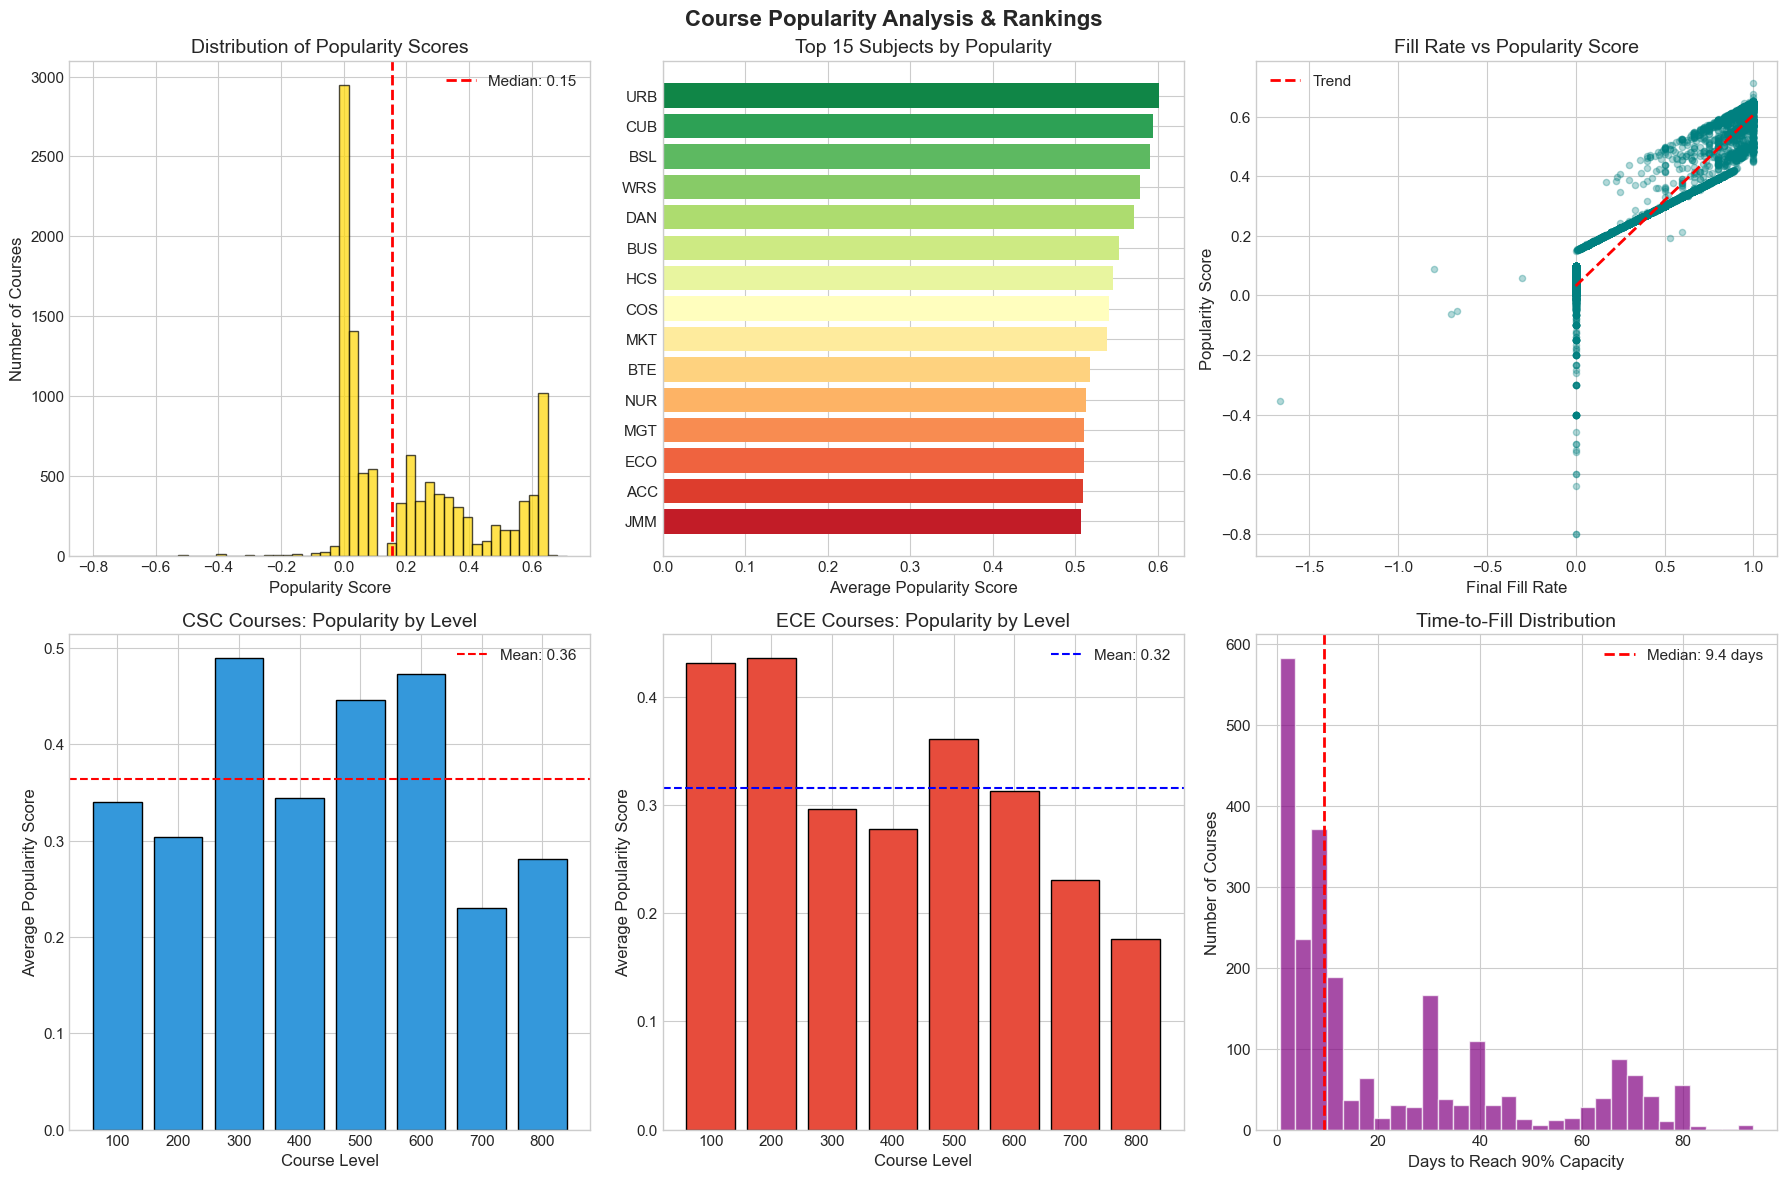


🏆 Popularity Summary:
   Total courses analyzed: 11,203
   CSC courses: 55
   ECE courses: 66
   Median popularity score: 0.154


In [ ]:
# ===============================================================
# VISUALIZATION 5: Course Popularity & Rankings Analysis
# ===============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Course Popularity Analysis & Rankings', fontsize=16, fontweight='bold')

# 1. Distribution of popularity scores
ax1 = axes[0, 0]
pop_scores = popularity['popularity_score'].replace([np.inf, -np.inf], np.nan).dropna()
pop_scores = pop_scores[(pop_scores > -1) & (pop_scores < 2)]
ax1.hist(pop_scores, bins=50, color='gold', edgecolor='black', alpha=0.7)
ax1.axvline(pop_scores.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {pop_scores.median():.2f}')
ax1.set_xlabel('Popularity Score')
ax1.set_ylabel('Number of Courses')
ax1.set_title('Distribution of Popularity Scores')
ax1.legend()

# 2. Top 15 subjects by average popularity
ax2 = axes[0, 1]
subject_pop = popularity.groupby('subjectCode')['popularity_score'].mean()
subject_pop = subject_pop.replace([np.inf, -np.inf], np.nan).dropna()
subject_pop = subject_pop[(subject_pop > -1) & (subject_pop < 2)].sort_values(ascending=False).head(15)
colors = sns.color_palette("RdYlGn_r", len(subject_pop))
bars = ax2.barh(subject_pop.index, subject_pop.values, color=colors)
ax2.set_xlabel('Average Popularity Score')
ax2.set_title('Top 15 Subjects by Popularity')
ax2.invert_yaxis()

# 3. Fill rate vs Popularity correlation
ax3 = axes[0, 2]
pop_clean = popularity[['final_fill_rate', 'popularity_score']].replace([np.inf, -np.inf], np.nan).dropna()
pop_clean = pop_clean[(pop_clean['popularity_score'] > -1) & (pop_clean['popularity_score'] < 2)]
ax3.scatter(pop_clean['final_fill_rate'], pop_clean['popularity_score'], alpha=0.3, s=20, c='teal')
ax3.set_xlabel('Final Fill Rate')
ax3.set_ylabel('Popularity Score')
ax3.set_title('Fill Rate vs Popularity Score')
# Add trend line
z = np.polyfit(pop_clean['final_fill_rate'], pop_clean['popularity_score'], 1)
p = np.poly1d(z)
ax3.plot([0, 1], [p(0), p(1)], "r--", linewidth=2, label='Trend')
ax3.legend()

# 4. CSC Courses by Level
ax4 = axes[1, 0]
csc_pop = popularity[popularity['subjectCode'] == 'CSC']
csc_by_level = csc_pop.groupby('course_level')['popularity_score'].mean()
csc_by_level = csc_by_level.replace([np.inf, -np.inf], np.nan).dropna()
csc_by_level = csc_by_level[(csc_by_level.index >= 1) & (csc_by_level.index <= 8)]
ax4.bar([f'{int(x)}00' for x in csc_by_level.index], csc_by_level.values, color='#3498db', edgecolor='black')
ax4.set_xlabel('Course Level')
ax4.set_ylabel('Average Popularity Score')
ax4.set_title('CSC Courses: Popularity by Level')
ax4.axhline(csc_by_level.mean(), color='red', linestyle='--', label=f'Mean: {csc_by_level.mean():.2f}')
ax4.legend()

# 5. ECE Courses by Level
ax5 = axes[1, 1]
ece_pop = popularity[popularity['subjectCode'] == 'ECE']
ece_by_level = ece_pop.groupby('course_level')['popularity_score'].mean()
ece_by_level = ece_by_level.replace([np.inf, -np.inf], np.nan).dropna()
ece_by_level = ece_by_level[(ece_by_level.index >= 1) & (ece_by_level.index <= 8)]
ax5.bar([f'{int(x)}00' for x in ece_by_level.index], ece_by_level.values, color='#e74c3c', edgecolor='black')
ax5.set_xlabel('Course Level')
ax5.set_ylabel('Average Popularity Score')
ax5.set_title('ECE Courses: Popularity by Level')
ax5.axhline(ece_by_level.mean(), color='blue', linestyle='--', label=f'Mean: {ece_by_level.mean():.2f}')
ax5.legend()

# 6. Time to Fill Distribution
ax6 = axes[1, 2]
ttf = popularity['time_to_fill_days'].replace([np.inf, -np.inf], np.nan).dropna()
ttf = ttf[ttf > 0]
if len(ttf) > 0:
    ax6.hist(ttf, bins=30, color='purple', edgecolor='white', alpha=0.7)
    ax6.axvline(ttf.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {ttf.median():.1f} days')
    ax6.set_xlabel('Days to Reach 90% Capacity')
    ax6.set_ylabel('Number of Courses')
    ax6.set_title('Time-to-Fill Distribution')
    ax6.legend()
else:
    ax6.text(0.5, 0.5, 'No courses reached 90%', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Time-to-Fill Distribution')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n  Popularity Summary:")
print(f"   Total courses analyzed: {len(popularity):,}")
print(f"   CSC courses: {len(csc_pop)}")
print(f"   ECE courses: {len(ece_pop)}")
print(f"   Median popularity score: {pop_scores.median():.3f}")


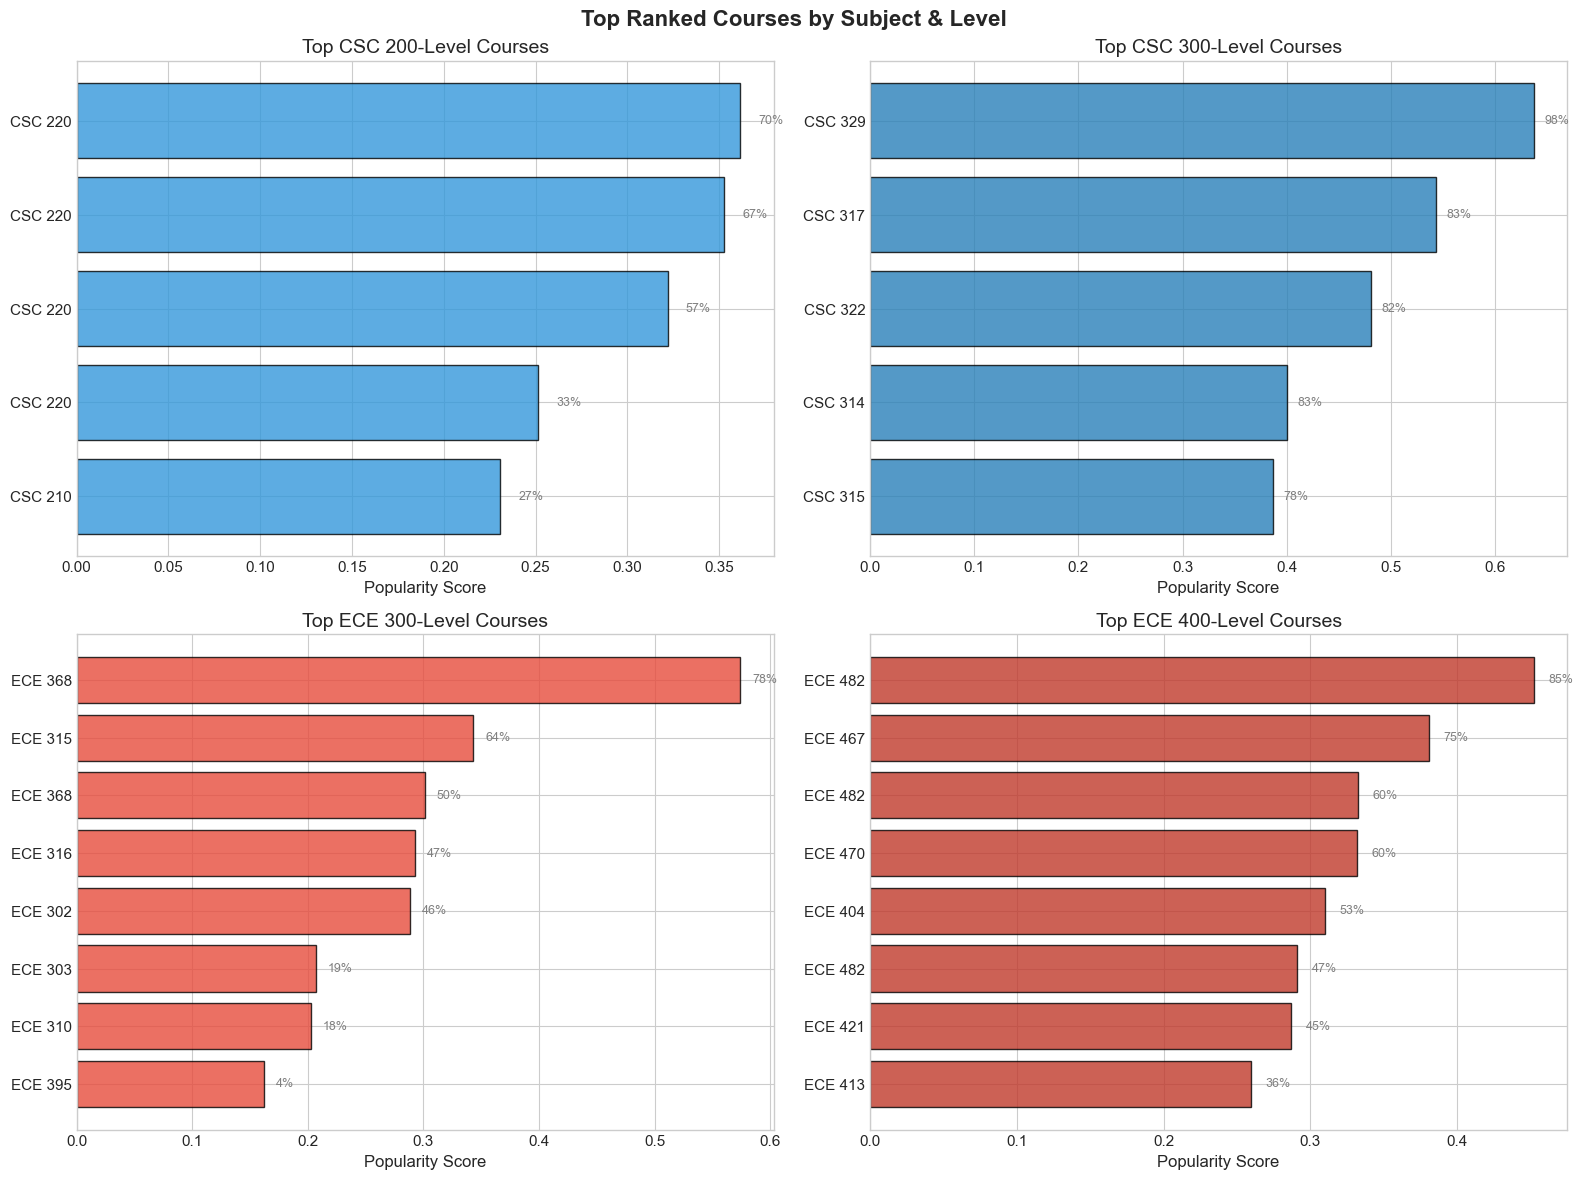


📋 TOP COURSE RANKINGS SUMMARY

CSC Department:
----------------------------------------

  200-Level Top 3:
    • CSC 220: Score=0.362, Fill=70%
    • CSC 220: Score=0.353, Fill=67%
    • CSC 220: Score=0.322, Fill=57%

  300-Level Top 3:
    • CSC 329: Score=0.637, Fill=98%
    • CSC 317: Score=0.543, Fill=83%
    • CSC 322: Score=0.481, Fill=82%

  400-Level Top 3:
    • CSC 423: Score=0.553, Fill=80%
    • CSC 410: Score=0.534, Fill=100%
    • CSC 411: Score=0.465, Fill=77%

ECE Department:
----------------------------------------

  200-Level Top 3:
    • ECE 205: Score=0.635, Fill=97%
    • ECE 218: Score=0.596, Fill=93%
    • ECE 211: Score=0.592, Fill=86%

  300-Level Top 3:
    • ECE 368: Score=0.574, Fill=78%
    • ECE 315: Score=0.343, Fill=64%
    • ECE 368: Score=0.302, Fill=50%

  400-Level Top 3:
    • ECE 482: Score=0.452, Fill=85%
    • ECE 467: Score=0.380, Fill=75%
    • ECE 482: Score=0.332, Fill=60%


In [ ]:
# ===============================================================
# VISUALIZATION 6: Top Course Rankings Visualization
# ===============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Top Ranked Courses by Subject & Level', fontsize=16, fontweight='bold')

level_mapping = {200: 2, 300: 3, 400: 4}

# Function to create ranking bar chart
def plot_top_courses(ax, subject, level, color):
    actual_level = level_mapping[level]
    subj_df = popularity[(popularity['subjectCode'] == subject) & (popularity['course_level'] == actual_level)]
    subj_df = subj_df.replace([np.inf, -np.inf], np.nan)
    subj_df = subj_df.dropna(subset=['popularity_score'])
    top_courses = subj_df.sort_values('popularity_score', ascending=False).head(8)
    
    if len(top_courses) > 0:
        y_pos = np.arange(len(top_courses))
        bars = ax.barh(y_pos, top_courses['popularity_score'].values, color=color, edgecolor='black', alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"{subject} {int(c)}" for c in top_courses['catalogNumber']])
        ax.set_xlabel('Popularity Score')
        ax.set_title(f'Top {subject} {level}-Level Courses')
        ax.invert_yaxis()
        
        # Add fill rate as text
        for i, (bar, fr) in enumerate(zip(bars, top_courses['final_fill_rate'])):
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{fr:.0%}', va='center', fontsize=9, color='gray')
    else:
        ax.text(0.5, 0.5, f'No {subject} {level}-level courses', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Top {subject} {level}-Level Courses')

# Plot top courses for each subject/level combination
plot_top_courses(axes[0, 0], 'CSC', 200, '#3498db')
plot_top_courses(axes[0, 1], 'CSC', 300, '#2980b9')
plot_top_courses(axes[1, 0], 'ECE', 300, '#e74c3c')
plot_top_courses(axes[1, 1], 'ECE', 400, '#c0392b')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("  TOP COURSE RANKINGS SUMMARY")
print("="*70)

for subject in ['CSC', 'ECE']:
    print(f"\n{subject} Department:")
    print("-" * 40)
    for display_level, actual_level in level_mapping.items():
        subj_df = popularity[(popularity['subjectCode'] == subject) & (popularity['course_level'] == actual_level)]
        subj_df = subj_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['popularity_score'])
        if len(subj_df) > 0:
            top = subj_df.sort_values('popularity_score', ascending=False).head(3)
            print(f"\n  {display_level}-Level Top 3:")
            for _, row in top.iterrows():
                print(f"    • {subject} {int(row['catalogNumber'])}: Score={row['popularity_score']:.3f}, Fill={row['final_fill_rate']:.0%}")
